## Social graphs & intercations
- Assignment 2
- Submission date: November 4th 2025

### Group 21
- Aryan Mirzazadeh - s204489
- Juan Manuel Rodriguez - s253505 
- Vladyslav Horbatenko - s254355

### Contributions

- Vlad: Worked on Part 1
- Aryan: Worked on Part 3 & 4
- Juan: Worked on Part 2 & 4

---

# Part 1: Analyze the Network

Part 1 analysis examines a directed network of rock performers extracted from Wikipedia, where nodes represent bands or artists and directed edges indicate hyperlinks between their Wikipedia pages. The network contains 484 nodes and 7,323 directed edges. Each node has a `content_length` attribute indicating the character count of the corresponding Wikipedia page.

---

## Data Setup

In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import requests
import io
from scipy import stats

We load the rock band network from the pre-processed data file. Isolated nodes will been removed, resulting in a single weakly connected component. We work with both the directed version (for in/out-degree analysis) and the undirected version (for centrality and other measures that require undirected graphs).

In [2]:
local_network = "data/rock_graph_node_link.json.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_network}"

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")

# remove isolated nodes
isolated_nodes = list(nx.isolates(G_bands))
G_bands.remove_nodes_from(isolated_nodes)

print(f"Loaded directed graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges.")
print(f"Isolated nodes removed: {len(isolated_nodes)}")
print(f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}")

# making an undirected version
G_und = G_bands.to_undirected()
largest_cc = max(nx.connected_components(G_und), key=len)
G_gcc = G_und.subgraph(largest_cc).copy()

print(f"\nUndirected version: {G_und.number_of_nodes()} nodes and {G_und.number_of_edges()} edges")
print(f"Giant Connected Component: {G_gcc.number_of_nodes()} nodes and {G_gcc.number_of_edges()} edges")

Loaded directed graph with 484 nodes and 7323 edges.
Isolated nodes removed: 4
Graph component count: 1

Undirected version: 484 nodes and 6019 edges
Giant Connected Component: 484 nodes and 6019 edges


---
## Network Visualization with ForceAtlas2

We use ForceAtlas2 as offers a more readable layout than traditional algorithms.

For this we use NetworkX's built-in ForceAtlas2 layout algorithm as suggested in week5 lecture.

In [3]:
# We use linglog sa True to get tighter clusters that can reflect communities in network.
# More on communities in following parts
pos_fa2 = nx.forceatlas2_layout(G_gcc, linlog=True, max_iter=1000, seed=42)

/Users/rifo/miniforge3/envs/socialGraphs270843/lib/python3.10/site-packages/networkx/drawing/layout.py:1442: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


In [4]:
# prep node attributes for visualization
degrees_gcc = dict(G_gcc.degree())
node_sizes = [degrees_gcc[n] * 10 for n in G_gcc.nodes()]  #  scale to have better visual representation (we decided to go with 7)
content_lengths = [G_gcc.nodes[n].get("content_length", 0) for n in G_gcc.nodes()]

In this plot, node size is proportional to degree, allowing prominent nodes with many connections to be easily seen, while node color represents the `content_length` attribute, roughly showing patterns in how bands are documented across the network.

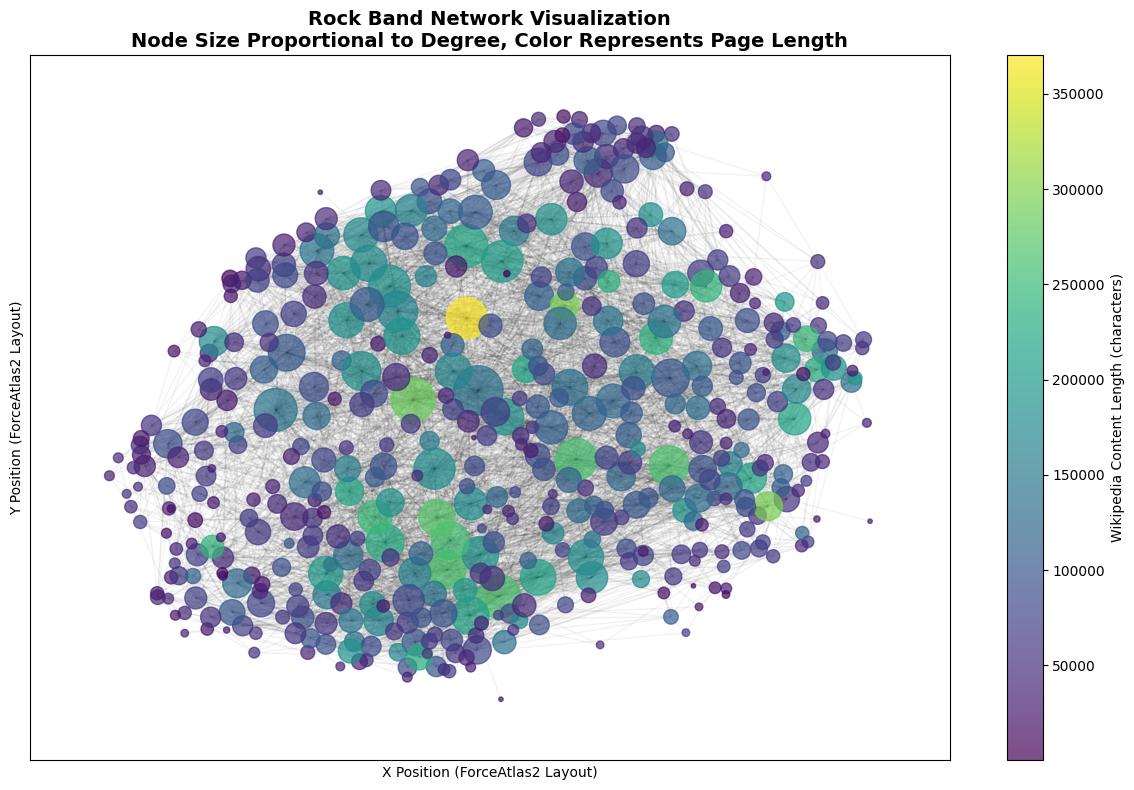

Visualization created with 484 nodes and 6019 edges


In [5]:
plt.figure(figsize=(12, 8))
nodes = nx.draw_networkx_nodes(
    G_gcc,
    pos_fa2,
    node_size=node_sizes,
    node_color=content_lengths,
    cmap=plt.cm.viridis,
    alpha=0.7
)
nx.draw_networkx_edges(G_gcc, pos_fa2, alpha=0.05, width=1, edge_color="black")

cbar = plt.colorbar(nodes, label="Wikipedia Content Length (characters)")
plt.xlabel("X Position (ForceAtlas2 Layout)")
plt.ylabel("Y Position (ForceAtlas2 Layout)")
plt.title(
    "Rock Band Network Visualization\nNode Size Proportional to Degree, Color Represents Page Length",
    fontsize=14,
    fontweight="bold"
)
plt.tight_layout()
plt.show()

print(f"Visualization created with {G_gcc.number_of_nodes()} nodes and {G_gcc.number_of_edges()} edges")


> **Figure 1** shows the network visualization using ForceAtlas2 layout. 

The spatial arrangement reveals clustering patterns and community structure (that we'll dive into in following sections), with larger nodes indicating bands that have more connections. The color gradient shows that bands with longer Wikipedia pages (warmer colors) are usually more connected in contrast with smaller and less connected pages, suggesting that documentation comprehensiveness and network position are related.

---

## Basic Network Structure

For directed networks such as Wikipedia, in-degree and out-degree must be analyzed separately because they capture different semantic meanings. In-degree reflects prestige or fame, how many other pages link to a particular band, indicating historical importance or influence. Out-degree reflects documentation scope, how comprehensively a band's own page documents related entities, which may be influenced by editorial practices and page comprehensiveness rather than historical importance alone.


In [6]:
# degree statistics for directed graph
in_degrees = dict(G_bands.in_degree())
out_degrees = dict(G_bands.out_degree())
in_deg_values = list(in_degrees.values())
out_deg_values = list(out_degrees.values())

In [7]:
# simple method to calculate mode
def calculate_mode(values):
    mode_result = stats.mode(values, keepdims=True)
    return mode_result.mode[0] if len(mode_result.mode) > 0 else None

In [8]:
print("In-Degree Statistics:")
print(f"  Mode:   {calculate_mode(in_deg_values)}")
print(f"  Min:    {np.min(in_deg_values)}")
print(f"  Max:    {np.max(in_deg_values)}")
print(f"  Std Dev: {np.std(in_deg_values):.2f}")

print("\nOut-Degree Statistics:")
print(f"  Mode:   {calculate_mode(out_deg_values)}")
print(f"  Min:    {np.min(out_deg_values)}")
print(f"  Max:    {np.max(out_deg_values)}")
print(f"  Std Dev: {np.std(out_deg_values):.2f}")

In-Degree Statistics:
  Mode:   3
  Min:    0
  Max:    119
  Std Dev: 17.00

Out-Degree Statistics:
  Mode:   12
  Min:    0
  Max:    74
  Std Dev: 10.63


To get a better understanding lets also look at correlation and degree distribution

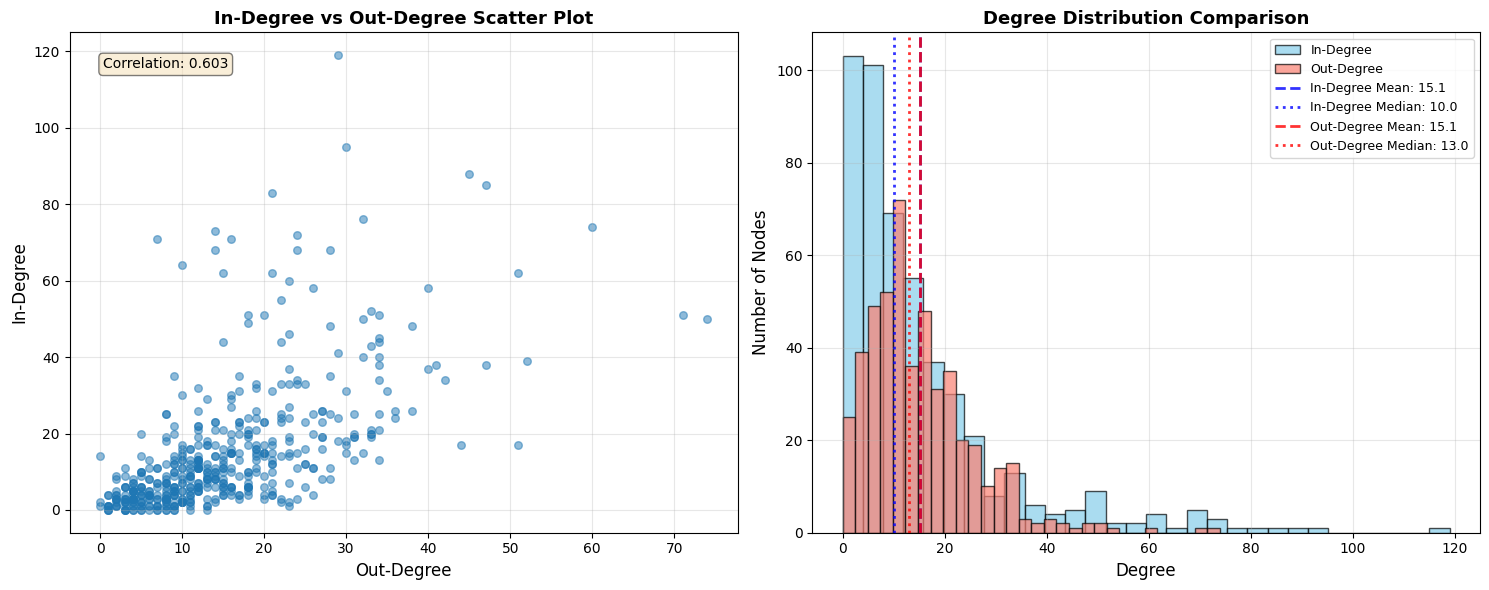

Correlation between in-degree and out-degree: 0.603


In [9]:
# calculate correlation
correlation = np.corrcoef(out_deg_values, in_deg_values)[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# scatter plot
axes[0].scatter(out_deg_values, in_deg_values, alpha=0.5, s=30)
axes[0].set_xlabel("Out-Degree", fontsize=12)
axes[0].set_ylabel("In-Degree", fontsize=12)
axes[0].set_title("In-Degree vs Out-Degree Scatter Plot", fontsize=13, fontweight="bold")
axes[0].grid(True, alpha=0.3)

# correlation coefficient
axes[0].text(0.05, 0.95, f"Correlation: {correlation:.3f}", 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# histogram of degree distributions
axes[1].hist(in_deg_values, bins=30, alpha=0.7, label="In-Degree", color="skyblue", edgecolor="black")
axes[1].hist(out_deg_values, bins=30, alpha=0.7, label="Out-Degree", color="salmon", edgecolor="black")

# vertical lines for mean and median
in_mean = np.mean(in_deg_values)
in_median = np.median(in_deg_values)
out_mean = np.mean(out_deg_values)
out_median = np.median(out_deg_values)

axes[1].axvline(in_mean, color="blue", linestyle="--", linewidth=2, label=f"In-Degree Mean: {in_mean:.1f}", alpha=0.8)
axes[1].axvline(in_median, color="blue", linestyle=":", linewidth=2, label=f"In-Degree Median: {in_median:.1f}", alpha=0.8)
axes[1].axvline(out_mean, color="red", linestyle="--", linewidth=2, label=f"Out-Degree Mean: {out_mean:.1f}", alpha=0.8)
axes[1].axvline(out_median, color="red", linestyle=":", linewidth=2, label=f"Out-Degree Median: {out_median:.1f}", alpha=0.8)

axes[1].set_xlabel("Degree", fontsize=12)
axes[1].set_ylabel("Number of Nodes", fontsize=12)
axes[1].set_title("Degree Distribution Comparison", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correlation between in-degree and out-degree: {correlation:.3f}")


> **Figure 2** shows the relationship between in-degree and out-degree through a scatter plot and histogram comparison. The degree statistics reveal that in-degree has mode 3, maximum 119, and standard deviation 17.00, while out-degree has mode 12, maximum 74, and standard deviation 10.63. Both distributions share mean values of 15.1, but their modes and medians differ significantly.

The scatter plot reveals a moderate positive correlation (0.603), indicating that bands with many outgoing links tend to receive more incoming links. Most nodes are clustered near the origin, with 322 out of 484 nodes (66.5%) falling within the [0,20] × [0,20] degree range. However, there is a notable spread extending towards higher degrees, with some nodes reaching in-degrees up to nearly 120 and out-degrees up to around 70. The histogram comparison shows that while both distributions are right-skewed, out-degrees are slightly shifted towards higher values compared to in-degrees, suggesting that bands tend to document more related entities than they are referenced by others on average. This also suggests that comprehensive documentation often correlates with greater recognition, though the imperfect correlation means these measures capture distinct aspects.

---

## Content Length and Documentation Patterns

Wikipedia page length, measured as the character count (`content_length`), reflects both editorial effort and overall importance. Understanding this relationship with degree measures helps us distinguish between whether longer pages result from more comprehensive documentation leading to more hyperlinks (correlating with out-degree), or whether more historically important bands receive longer, more detailed pages that naturally accumulate more incoming links (correlating with in-degree).

To assess these relationships, we compute both **Pearson correlation** and **Spearman correlation**. Pearson correlation measures linear relationships between variables, assuming normal distribution and detecting proportional changes. Spearman correlation measures monotonic relationships, ranking-based and will be more robust to outliers and non-linear but monotonic patterns. 

So, Pearson reveals whether longer pages systematically produce more links (linear relationship), while Spearman detects whether more comprehensive pages generally have more connections even if the relationship isn't perfectly linear (monotonic relationship).


In [10]:
# correlation between content_length and degrees
content_lengths_list = [G_bands.nodes[n].get("content_length", 0) for n in G_bands.nodes()]

# calculate correlations
corr_out = np.corrcoef(out_deg_values, content_lengths_list)[0, 1]
corr_in = np.corrcoef(in_deg_values, content_lengths_list)[0, 1]

# Spearman correlation (non-parametric)
spearman_out = stats.spearmanr(out_deg_values, content_lengths_list)[0]
spearman_in = stats.spearmanr(in_deg_values, content_lengths_list)[0]

print("Correlation between content_length and degrees:")
print(f"\nContent_length vs Out-degree:")
print(f"  Pearson correlation:  {corr_out:.4f}")
print(f"  Spearman correlation: {spearman_out:.4f}")

print(f"\nContent_length vs In-degree:")
print(f"  Pearson correlation:  {corr_in:.4f}")
print(f"  Spearman correlation: {spearman_in:.4f}")

Correlation between content_length and degrees:

Content_length vs Out-degree:
  Pearson correlation:  0.6337
  Spearman correlation: 0.6714

Content_length vs In-degree:
  Pearson correlation:  0.6627
  Spearman correlation: 0.6411


The Pearson correlation with in-degree (0.663) is slightly stronger than with out-degree (0.634), suggesting that historically important bands (those receiving many incoming links) tend to have longer Wikipedia pages, supporting the hypothesis that **fame drives page length**. However, both correlations are substantial, indicating that both **documentation scope (out-degree) and historical importance (in-degree) contribute to page length**. 

The Spearman correlations being similar to or slightly higher than Pearson correlations (especially for out-degree: 0.671 vs 0.634) suggests the relationships are robust and monotonic, not just linear. This indicates that more comprehensive Wikipedia pages generally have more connections, even if the relationship isn't perfectly proportional.

---


## Centrality Analysis: Multiple Perspectives on Node Importance

We compute four centrality measures (degree, betweenness, eigenvector, and closeness) to understand different aspects of node importance. These measures should reveal distinct roles that nodes play in the network, and comparing helps characterize the multifaceted nature of importance in this Wikipedia network.


In [11]:
# centrality measures on undirected graph
degree_cent = nx.degree_centrality(G_und)
betweenness_cent = nx.betweenness_centrality(G_und, normalized=True)
eigenvector_cent = nx.eigenvector_centrality(G_und, max_iter=1000, tol=1e-06)
closeness_cent = nx.closeness_centrality(G_und)

In [12]:
# top 5 nodes for each centrality measure
top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_eigenvector = sorted(eigenvector_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_closeness = sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:5]

In [13]:
print("Top 5 nodes by Degree Centrality:")
for i, (node, cent) in enumerate(top_degree, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

print("\nTop 5 nodes by Betweenness Centrality:")
for i, (node, cent) in enumerate(top_betweenness, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

print("\nTop 5 nodes by Eigenvector Centrality:")
for i, (node, cent) in enumerate(top_eigenvector, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

print("\nTop 5 nodes by Closeness Centrality:")
for i, (node, cent) in enumerate(top_closeness, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

Top 5 nodes by Degree Centrality:
1. Led Zeppelin                  : 0.2629
2. Queen (band)                  : 0.2070
3. Bob Dylan                     : 0.2070
4. Deep Purple                   : 0.1988
5. Metallica                     : 0.1988

Top 5 nodes by Betweenness Centrality:
1. Led Zeppelin                  : 0.0464
2. Bob Dylan                     : 0.0375
3. Queen (band)                  : 0.0310
4. Deep Purple                   : 0.0293
5. Jimi Hendrix                  : 0.0260

Top 5 nodes by Eigenvector Centrality:
1. Led Zeppelin                  : 0.1726
2. Metallica                     : 0.1535
3. Black Sabbath                 : 0.1522
4. Queen (band)                  : 0.1457
5. Deep Purple                   : 0.1453

Top 5 nodes by Closeness Centrality:
1. Led Zeppelin                  : 0.5565
2. Queen (band)                  : 0.5433
3. Bob Dylan                     : 0.5397
4. David Bowie                   : 0.5343
5. Deep Purple                   : 0.5337


Led Zeppelin consistently ranks first across all measures, meaning that it plays a central role in the network. Degree centrality identifies nodes with the most direct connections, with Led Zeppelin (0.2629) having the highest, followed by Queen (band) and Bob Dylan (both 0.2070). 

Betweenness centrality measures how often a node lies on shortest paths, with Jimi Hendrix appearing in the top 5 for betweenness but not degree, suggesting he serves as an important connector between different network parts. 

Eigenvector centrality considers connection quality, with heavy metal bands like Metallica and Black Sabbath ranking high, showing the interconnected nature of the heavy metal community. 

Closeness centrality measures efficient reachability, with David Bowie appearing in the top 5 for closeness but not other measures, showing his specialized positioning. 

The overlap but not identity of top nodes across measures shows that importance in this network is multifaceted.

---

In [14]:
# centrality values
degree_values = list(degree_cent.values())
betweenness_values = list(betweenness_cent.values())
eigenvector_values = list(eigenvector_cent.values())
closeness_values = list(closeness_cent.values())

# calculate correlations
corr_db = np.corrcoef(degree_values, betweenness_values)[0, 1]
corr_de = np.corrcoef(degree_values, eigenvector_values)[0, 1]
corr_dc = np.corrcoef(degree_values, closeness_values)[0, 1]

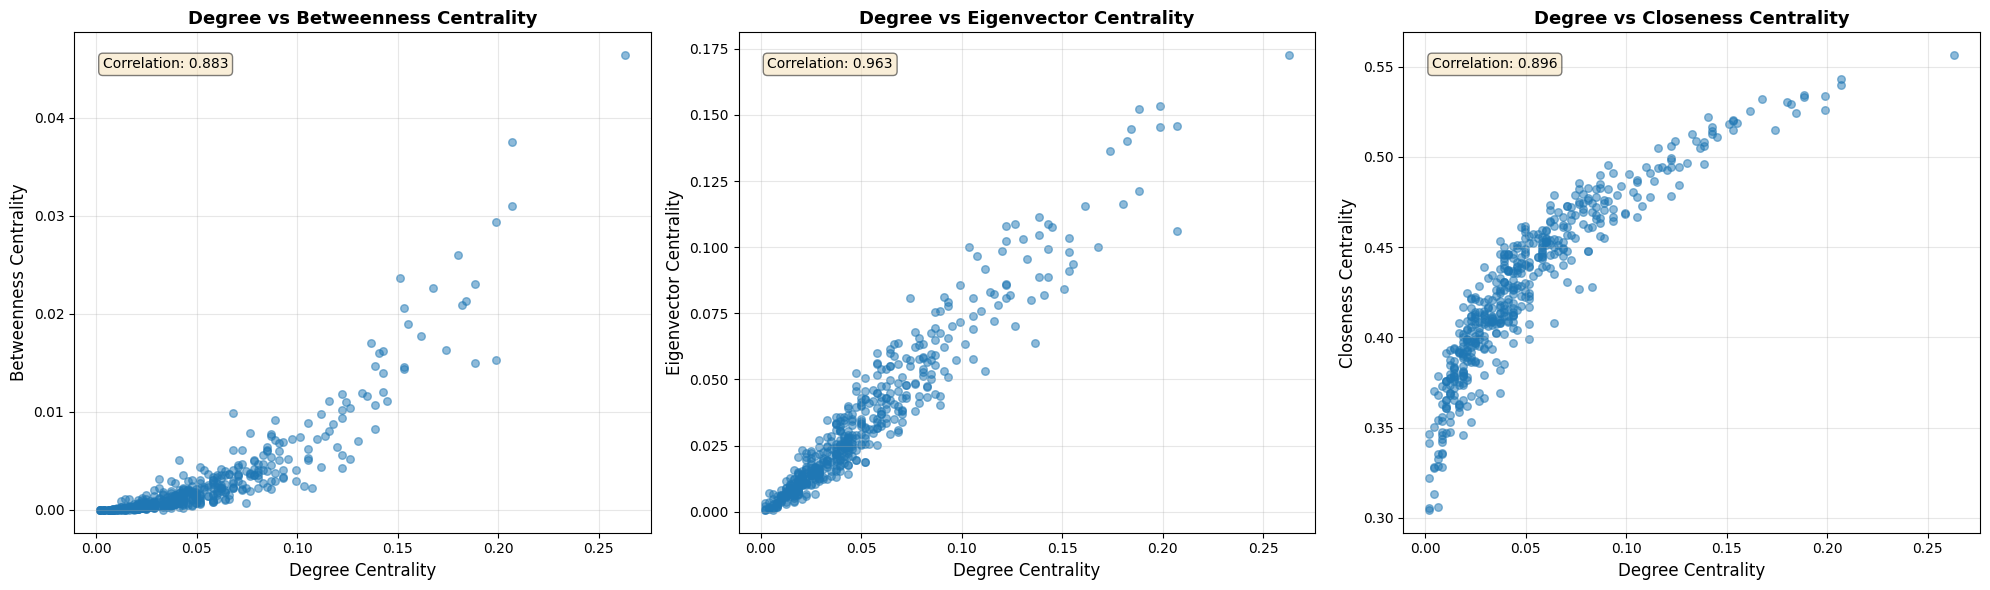

Correlation coefficients:
	Degree vs Betweenness: 0.883
	Degree vs Eigenvector: 0.963
	Degree vs Closeness: 0.896


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Degree vs Betweenness
axes[0].scatter(degree_values, betweenness_values, alpha=0.5, s=30)
axes[0].set_xlabel("Degree Centrality", fontsize=12)
axes[0].set_ylabel("Betweenness Centrality", fontsize=12)
axes[0].set_title("Degree vs Betweenness Centrality", fontsize=13, fontweight="bold")
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f"Correlation: {corr_db:.3f}", 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Degree vs Eigenvector
axes[1].scatter(degree_values, eigenvector_values, alpha=0.5, s=30)
axes[1].set_xlabel("Degree Centrality", fontsize=12)
axes[1].set_ylabel("Eigenvector Centrality", fontsize=12)
axes[1].set_title("Degree vs Eigenvector Centrality", fontsize=13, fontweight="bold")
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, f"Correlation: {corr_de:.3f}", 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Degree vs Closeness
axes[2].scatter(degree_values, closeness_values, alpha=0.5, s=30)
axes[2].set_xlabel("Degree Centrality", fontsize=12)
axes[2].set_ylabel("Closeness Centrality", fontsize=12)
axes[2].set_title("Degree vs Closeness Centrality", fontsize=13, fontweight="bold")
axes[2].grid(True, alpha=0.3)
axes[2].text(0.05, 0.95, f"Correlation: {corr_dc:.3f}", 
             transform=axes[2].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Correlation coefficients:")
print(f"\tDegree vs Betweenness: {corr_db:.3f}")
print(f"\tDegree vs Eigenvector: {corr_de:.3f}")
print(f"\tDegree vs Closeness: {corr_dc:.3f}")


> **Figure 3** shows scatter plots comparing different centrality measures, revealing strong correlations between measures ($r = 0.883$ for degree vs betweenness, $r = 0.963$ for degree vs eigenvector, $r = 0.896$ for degree vs closeness). These correlations indicate that highly connected nodes tend to serve multiple roles simultaneously.

Having such high correlation between degree and eigenvector ($r = 0.963$) shows that nodes with many direct connections are almost always connected to other important nodes, creating influential neighborhoods around network hubs. 

Which we can also see from detailed ranking above, with Led Zeppelin ranking first across all measures, showing its central role as both a hub (highest degree at $0.2629$), bridge between communities (highest betweenness at $0.0464$), prestigious node (highest eigenvector at $0.1726$), and well-positioned node (highest closeness at $0.5565$). Similarly, Queen (band), Bob Dylan, Deep Purple, and Metallica consistently appear in the top 5 across multiple measures.

These findings reveal the nuanced nature of importance in the network. Meaning, while hubs often serve multiple roles simultaneously, some nodes play specialized roles that highlight different aspects of network structure beyond simple connectivity.

---


## Assortativity: Mixing Patterns

Assortativity measures whether similar nodes connect to similar nodes (homophily) or dissimilar nodes (heterophily), revealing patterns in how the network organizes itself.


In [16]:
# degree assortativity
degree_assort = nx.degree_assortativity_coefficient(G_und)
print(f"Degree assortativity coefficient: {degree_assort:.4f}")

# attribute assortativity for content_length
# using attribute_assortativity_coefficient as specified in the exercise hint
attribute_assort = nx.attribute_assortativity_coefficient(G_und, "content_length")
print(f"Attribute assortativity (content_length): {attribute_assort:.4f}")

Degree assortativity coefficient: 0.0088
Attribute assortativity (content_length): -0.0034


In [17]:
# interpretation
print("\nInterpretation:")
if abs(degree_assort) < 0.1:
    print(f"\tNeutral degree assortativity ({degree_assort:.4f}) indicates random mixing by degree.")
    print("\tThe value is close to zero, suggesting no strong tendency for similar-degree nodes to connect.")
elif degree_assort > 0:
    print(f"\tPositive degree assortativity ({degree_assort:.4f}) indicates that high-degree nodes tend to connect to high-degree nodes.")
else:
    print(f"\tNegative degree assortativity ({degree_assort:.4f}) indicates that high-degree nodes tend to connect to low-degree nodes.")
    print("\tThis creates a hub-and-spoke structure.")

if abs(attribute_assort) < 0.05:
    print(f"\tWeak attribute assortativity ({attribute_assort:.4f}) suggests content_length doesn't strongly influence connections.")
elif attribute_assort > 0:
    print(f"\tPositive attribute assortativity ({attribute_assort:.4f}) indicates that nodes with similar content_length values tend to connect.")
    print("\tThis may reflect common editorial practices or similar levels of historical importance.")
else:
    print(f"\tNegative attribute assortativity ({attribute_assort:.4f}) indicates that nodes with different content_length values tend to connect.")



Interpretation:
	Neutral degree assortativity (0.0088) indicates random mixing by degree.
	The value is close to zero, suggesting no strong tendency for similar-degree nodes to connect.
	Weak attribute assortativity (-0.0034) suggests content_length doesn't strongly influence connections.


**Degree assortativity**: The coefficient of $0.0088$ is close to zero, meaning nearly neutral mixing by degree in this network. This shows that high-degree nodes (like Led Zeppelin) do not strongly prefer connecting to other high-degree nodes, nor do they prefer connecting to low-degree nodes.
 
The network exhibits essentially random mixing by degree, meaning that well-connected bands are equally likely to link to well-connected or less-connected bands. 


**Attribute assortativity**: The coefficient for `content_length` is $-0.0034$, which is close to zero, indicating that bands with similar Wikipedia page lengths do not tend to connect preferentially. This suggests that editorial practices (whether a page is comprehensive or brief) do not strongly influence which bands are linked together. 

Bands with long Wikipedia pages are just as likely to link to bands with short pages as to other bands with long pages. This means that connection patterns in this network are not primarily driven by page comprehensiveness, but rather by other factors such as musical relationships, shared history, or collaborative connections.

---


## Weight Computation for Backbone Extraction

To extract network backbones, we assign weights to edges based on **edge betweenness centrality**, which measures how many shortest paths pass through each edge. 

We construct three weighted networks:

1. **Weighted Network 1**: edge weights as edge betweenness, normalized to [1, 100].
2. **Weighted Network 2**: edge weights as 1 / (edge betweenness), normalized to [1, 100].

In [18]:
# edge betweenness centrality for the undirected Giant Connected Component
print(f"Computing edge betweenness for {G_gcc.number_of_edges()} edges...")

edge_betweenness = nx.edge_betweenness_centrality(G_gcc, normalized=True)
print("Done!")

Computing edge betweenness for 6019 edges...
Done!


In [19]:
# Weighted Network 1: weights = edge betweenness (normalized 1-100)
eb_values = list(edge_betweenness.values())
eb_min = min(eb_values)
eb_max = max(eb_values)

# Normalize to [1, 100]
if eb_max > eb_min:
    G_weighted1 = G_gcc.copy()
    for (u, v), weight in edge_betweenness.items():
        normalized_weight = 1 + 99 * (weight - eb_min) / (eb_max - eb_min)
        G_weighted1[u][v]['weight'] = normalized_weight
else:
    G_weighted1 = G_gcc.copy()
    for (u, v) in G_weighted1.edges():
        G_weighted1[u][v]['weight'] = 1

print(f"Weighted Network 1: Edge weights normalized from [{eb_min:.6f}, {eb_max:.6f}] to [1, 100]")

Weighted Network 1: Edge weights normalized from [0.000047, 0.004132] to [1, 100]


In [20]:
# Weighted Network 2: weights = 1 / (edge betweenness), normalized
G_weighted2 = G_gcc.copy()
eb_inverse_values = [1 / w if w > 0 else 0 for w in eb_values]
inv_min = min([v for v in eb_inverse_values if v > 0])
inv_max = max(eb_inverse_values)

if inv_max > inv_min:
    for (u, v), weight in edge_betweenness.items():
        if weight > 0:
            inv_weight = 1 / weight
            normalized_weight = 1 + 99 * (inv_weight - inv_min) / (inv_max - inv_min)
            G_weighted2[u][v]['weight'] = normalized_weight
        else:
            G_weighted2[u][v]['weight'] = 1
else:
    for (u, v) in G_weighted2.edges():
        G_weighted2[u][v]['weight'] = 1

print(f"Weighted Network 2: Inverse edge betweenness, normalized to [1, 100]")


Weighted Network 2: Inverse edge betweenness, normalized to [1, 100]


## Network Backbone Extraction

We extract network backbones to simplify the network and reveal its core structure. For Networks 1 and 2, we implement the **Disparity Filter** to identify statistically significant edges based on whether edge weights are unlikely under a null hypothesis of random weight distribution.

In [21]:
def disparity_filter_impl(table, undirected=True):
    """
    Implement disparity filter to compute significance scores for edges.
    Returns table with columns: src, trg, nij, score
    """
    table = table.copy()
    # for each source node, calculate strength (sum of edge weights) and degree
    node_strength = table.groupby('src')['nij'].sum().reset_index()
    node_strength.columns = ['src', 'strength']
    node_degree = table.groupby('src')['trg'].count().reset_index()
    node_degree.columns = ['src', 'degree']
    
    # Merge with original table
    table = table.merge(node_strength, on='src', how='left')
    table = table.merge(node_degree, on='src', how='left')
    
    # Calculate disparity filter score
    # score = 1.0 - ((1.0 - (w_ij / s_i))^(k_i - 1))
    # Handle edge case where degree = 1 (avoid 0^0)
    mask_degree_gt_1 = table['degree'] > 1
    table['score'] = 0.0  # Default score
    # For nodes with degree > 1, calculate the score
    table.loc[mask_degree_gt_1, 'score'] = 1.0 - ((1.0 - (table.loc[mask_degree_gt_1, 'nij'] / table.loc[mask_degree_gt_1, 'strength'])) ** (table.loc[mask_degree_gt_1, 'degree'] - 1))
    
    # For undirected graphs, take maximum score for each edge pair
    if undirected:
        table['edge'] = table.apply(lambda x: "%s-%s" % (min(x['src'], x['trg']), max(x['src'], x['trg'])), axis=1)
        table_maxscore = table.groupby('edge')['score'].max().reset_index()
        table = table.merge(table_maxscore, on='edge', suffixes=('', '_max'))
        table['score'] = table['score_max']
        table = table.drop_duplicates(subset=['edge'])
        table = table.drop(['edge', 'score_max'], axis=1)
    
    return table[['src', 'trg', 'nij', 'score']]

The disparity filter computes significance scores using the formula: $score = 1.0 - ((1.0 - (w_{ij} / s_i))^{(k_i - 1)})$, where $w_{ij}$ is the edge weight, $s_i$ is the node strength (sum of edge weights), and $k_i$ is the node degree. Higher scores indicate edges that are statistically significant given the null hypothesis of random weight distribution. For undirected graphs, we use the maximum score for each edge pair.


In [22]:
def nx_to_backboning_table(G):
    edges = []
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1.0)
        edges.append({'src': u, 'trg': v, 'nij': weight})
    return pd.DataFrame(edges)

def backboning_table_to_nx(table):
    G = nx.Graph()
    for _, row in table.iterrows():
        G.add_edge(row['src'], row['trg'], weight=row['nij'])
    return G

In [23]:
table1 = nx_to_backboning_table(G_weighted1)
table2 = nx_to_backboning_table(G_weighted2)

In [24]:
table1_scored = disparity_filter_impl(table1, undirected=True)
table2_scored = disparity_filter_impl(table2, undirected=True)

In [25]:
alpha_threshold = 0.8
backbone1_table = table1_scored[table1_scored['score'] > alpha_threshold][['src', 'trg', 'nij']]
backbone2_table = table2_scored[table2_scored['score'] > alpha_threshold][['src', 'trg', 'nij']]

backbone1 = backboning_table_to_nx(backbone1_table)
backbone2 = backboning_table_to_nx(backbone2_table)

print(f"Backbone 1: {backbone1.number_of_nodes()} nodes, {backbone1.number_of_edges()} edges")
print(f"Backbone 2: {backbone2.number_of_nodes()} nodes, {backbone2.number_of_edges()} edges")


Backbone 1: 413 nodes, 583 edges
Backbone 2: 256 nodes, 378 edges


We apply the disparity filter to Networks 1 and 2 to compute significance scores, then filter edges with scores above the threshold (0.8). This retains only the most statistically significant edges, substantially reducing network density.


/Users/rifo/miniforge3/envs/socialGraphs270843/lib/python3.10/site-packages/networkx/drawing/layout.py:1442: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


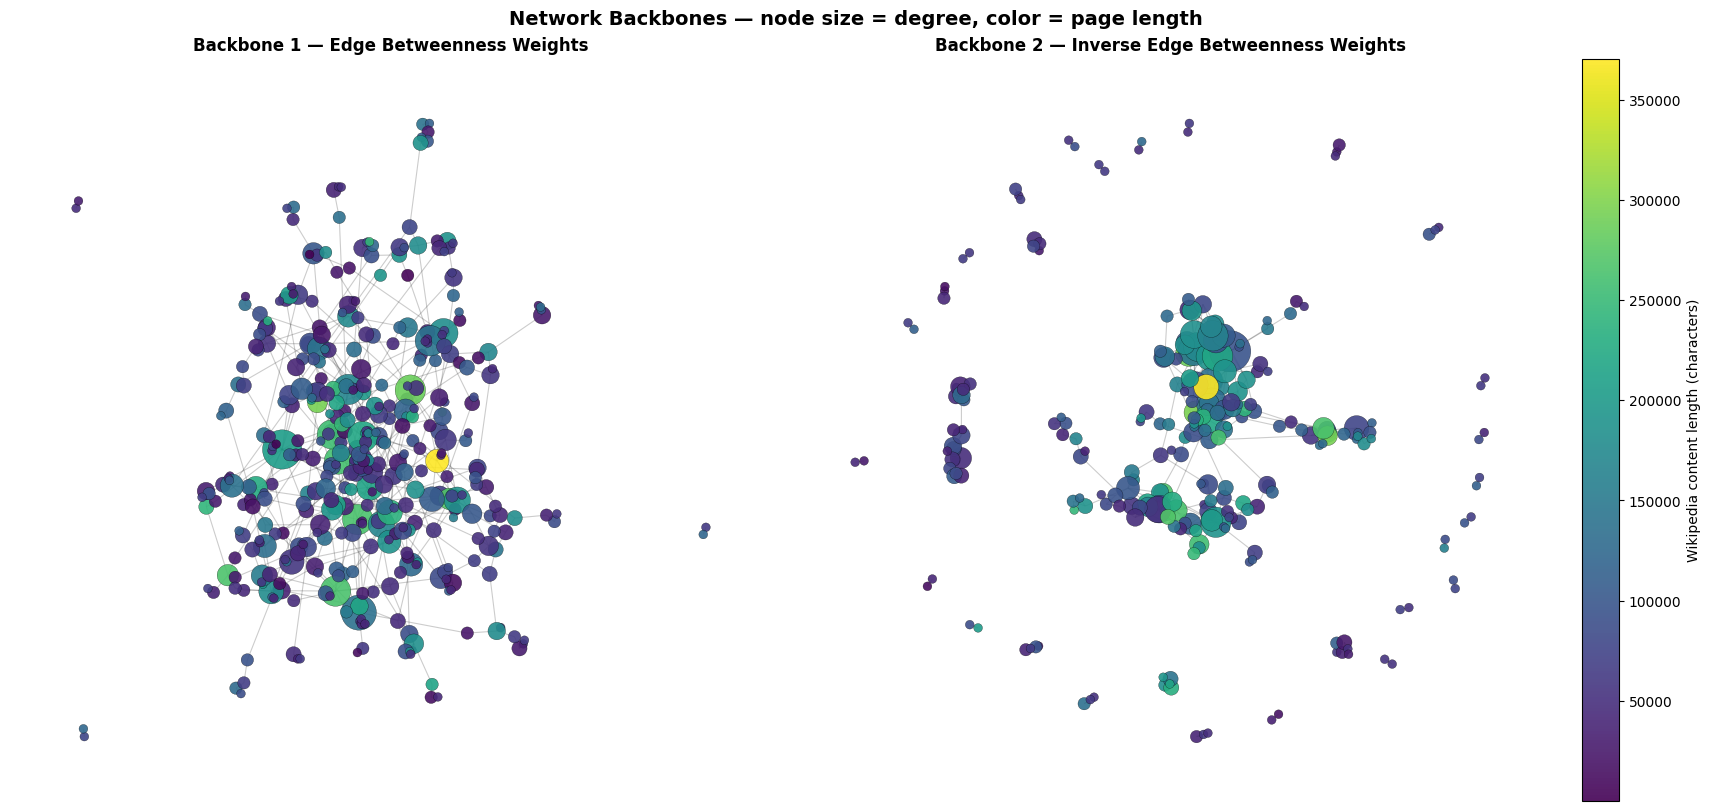

In [26]:
for BB in (backbone1, backbone2):
    for n in BB.nodes():
        BB.nodes[n]["content_length"] = G_gcc.nodes[n].get("content_length", 0)

all_lengths = [
    G_gcc.nodes[n].get("content_length", 0)
    for n in G_gcc.nodes()
    if isinstance(G_gcc.nodes[n].get("content_length", None), (int, float))
]
vmin, vmax = min(all_lengths), max(all_lengths)

# --- layout helper with FA2 fallback ---
def get_layout(G, seed=42):
    return nx.forceatlas2_layout(G, linlog=True, max_iter=400, seed=seed)

# --- combined side-by-side plot ---
fig, axes = plt.subplots(1, 2, figsize=(17, 8), constrained_layout=True)

for ax, (BB, title) in zip(
    axes,
    [
        (backbone1, "Backbone 1 — Edge Betweenness Weights"),
        (backbone2, "Backbone 2 — Inverse Edge Betweenness Weights"),
    ],
):
    pos = get_layout(BB)
    deg = dict(BB.degree())
    sizes = [max(20, d * 40) for d in deg.values()]
    colors = [BB.nodes[n].get("content_length", 0) for n in BB.nodes()]

    nodes = nx.draw_networkx_nodes(
        BB, pos, node_size=sizes, node_color=colors,
        cmap=plt.cm.viridis, vmin=vmin, vmax=vmax,
        alpha=0.9, linewidths=0.2, edgecolors="black", ax=ax
    )
    nx.draw_networkx_edges(BB, pos, alpha=0.2, width=0.8, edge_color="black", ax=ax)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.axis("off")

# shared colorbar
cbar = fig.colorbar(nodes, ax=axes.ravel().tolist(), fraction=0.03, pad=0.02)
cbar.set_label("Wikipedia content length (characters)", fontsize=10)

plt.suptitle("Network Backbones — node size = degree, color = page length", fontsize=14, fontweight="bold")
plt.show()


> **Figure 4** shows two network backbone visualizations extracted using different methods. 

This visualization compares two network backbones colored by Wikipedia page length. 

**Backbone 1** (left) selects high-betweenness edges, forming a dense central cluster where well-documented artists (bright nodes) concentrate in the core. 

**Backbone 2** (right) selects low-betweenness edges, showing a fragmented structure with well-documented artists scattered across disconnected components. 

Node size represents degree centrality, while color represents Wikipedia content length.

# Part 2: Genres and communities and plotting 


---
## Data Setup
Below we import the same network as in part 1, however this version contains genre node properties for each band/artist.

This is so that we can skip the hassle of running all of code for parsing wiki page contents over and over again.

In [27]:
# Load graph with genres without including isolated nodes
local_network = "data/rock_band_graph_isolated_genres.json.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_network}"

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
    print(
        f"Loaded graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges containing bands and genres.",
        f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
        sep="\n",
    )
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")

Loaded graph with 484 nodes and 7323 edges containing bands and genres.
Graph component count: 1


---
## Genres and Modularity



**Modularity** measures how well a network is divided into communities.  
It compares the actual number of edges within communities to the expected number if edges were randomly distributed while preserving node degrees.  
The modularity score ranges from **–0.5 to 1.0**, with the following interpretations:

- **High modularity (≈ 1):** Well-defined communities with dense internal connections and few connections between them.  
- **Low modularity (≈ 0):** Poorly defined communities, with edges distributed almost randomly.  
- **Negative modularity:** Worse than random, with more edges connecting different communities than nodes within them.

The network has to be divided into communities/partitions to be able to measure its modularity. In our network of artists, each node represents a musician or band containing the **genres** associated with them, and edges represent Wikipedia links between them. We will use these genres as grouping features to form communities within the network and then, using the modularity metric, measure how accurately these communities are formed.

##### **Network's modularity calculation**

To calculate the network's modularity we will use the function below, based on the equation $(9.12)$ described in the *Network Science* book:
$$M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right]$$

where
- $L_c =$ number of edges within communities/partition $c$  
- $L =$ total number of edges  
- $k_c =$ sum of degrees of nodes in communities/partition $c$

In [28]:
# Modularity Calculation Function (Equation 9.12)
def calculate_modularity(G, partition):
    if len(G.edges()) == 0:
        return 0.0
    L = G.number_of_edges()
    
    # Group nodes by community
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)

    modularity = 0.0
    
    # Calculate modularity for each community
    for comm, nodes_in_comm in communities.items():
        L_c = 0
        for u in nodes_in_comm:
            for v in nodes_in_comm:
                if G.has_edge(u, v):
                    L_c += 1
        L_c = L_c / 2
        k_c = sum(G.degree(node) for node in nodes_in_comm)
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2
    
    return modularity

### Genre Statistics & Overview

In [29]:
from collections import Counter

total_genres = 0
nodes_with_genres = 0
distinct_genres_set = set()
for i, (node, genres) in enumerate(G_bands.nodes(data=True)):
    if "genres" in genres:
        nodes_with_genres += 1
        total_genres += len(genres["genres"])
        distinct_genres_set.update(genres["genres"])
avg_genres = total_genres / nodes_with_genres if nodes_with_genres > 0 else 0
distinct_genres = len(distinct_genres_set)
# Report statistics
print("\nGenre Extraction Statistics:")
print(f"- Number of nodes with genres: {nodes_with_genres}")
print(f"- Average number of genres per node: {avg_genres:.2f}")
print(f"- Total distinct genres: {distinct_genres}")


Genre Extraction Statistics:
- Number of nodes with genres: 482
- Average number of genres per node: 3.58
- Total distinct genres: 191


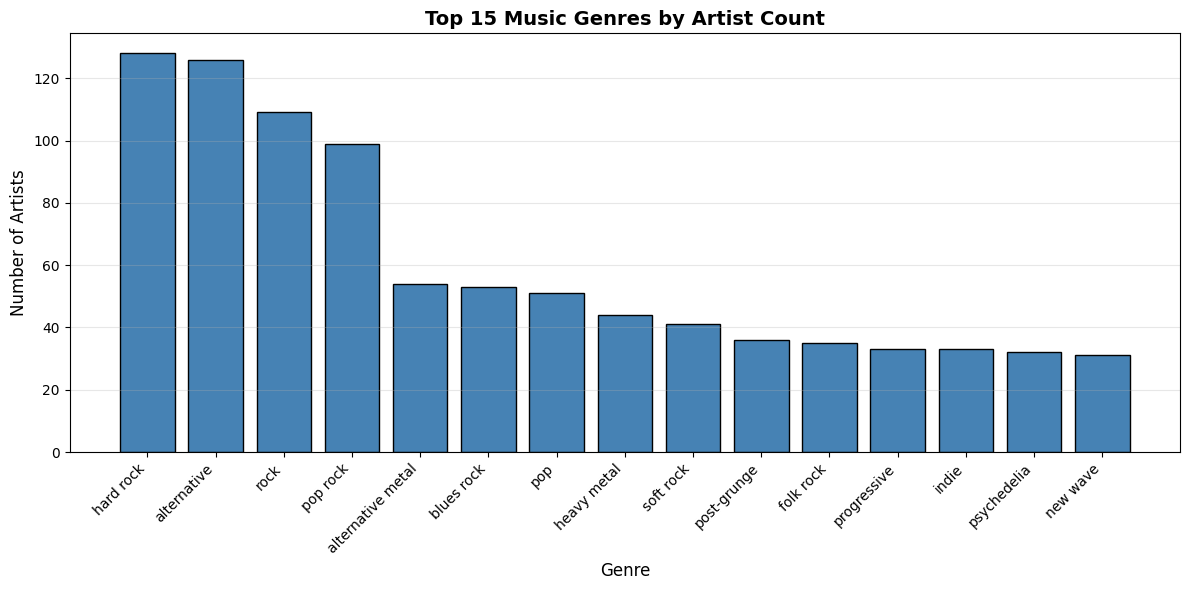

In [30]:
import matplotlib.pyplot as plt
# Count genre occurrences
genre_counter = Counter()
for node, genres in G_bands.nodes(data=True):
    if "genres" in genres:
        genre_counter.update(genres["genres"])
# Get top 15 genres
top_15_genres = genre_counter.most_common(15)
# Create histogram for top 15 genres
plt.figure(figsize=(12, 6))
genres_names = [g[0] for g in top_15_genres]
genres_values = [g[1] for g in top_15_genres]

plt.bar(range(len(genres_names)), genres_values, color="steelblue", edgecolor="black")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Artists", fontsize=12)
plt.title("Top 15 Music Genres by Artist Count", fontsize=14, fontweight="bold")
plt.xticks(range(len(genres_names)), genres_names, rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", alpha=0.3)
plt.show()

> Figure 5 shows the artist distribution across the top 15 genres.  

The distribution is noticeably **skewed**, with the categories being mainly types of **rock music** including *hard rock*, *alternative*, and *pop rock* alongside *alternative* music in general.  

---

## Community Detection and Comparison with Genres

Firstly we will convert our network with genres to an undirected network and remove all nodes without any genres.

In [31]:
# filter the graph to only include nodes with genres
G_undirected = G_bands.to_undirected()

nodes_with_genres_list = [
    node
    for node in G_undirected.nodes()
    if "genres" in G_undirected.nodes[node] and G_undirected.nodes[node]["genres"]
]

G_genres = G_undirected.subgraph(nodes_with_genres_list).copy()

To assess whether music genres naturally form well-defined communities in the artist network, we explored several partitioning strategies:

- Selecting the 1st genre which is usually `rock`.
- Selecting the 2nd genre *that's not `rock`* as the genre-assignment for all nodes that have more than one genre
- Using a random genre from the list genre as the node-label for those nodes with more than one genre


In [32]:
# PARTITION STRATEGY 1 : FIRST GENRE
import random
print("PARTITION STRATEGY 1 : FIRST GENRE\n")

partition_first = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    partition_first[node] = genres[0]

communities_first = set(partition_first.values())
print(f"Number of genre-based communities: {len(communities_first)}")

# Calculate modularity
modularity_first = calculate_modularity(G_genres, partition_first)
print(f"Modularity (first genre): {modularity_first:.4f}")

# Verify with NetworkX
modularity_nx_first = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_first[n] == genre])
        for genre in communities_first
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_first:.4f}")

PARTITION STRATEGY 1 : FIRST GENRE

Number of genre-based communities: 74
Modularity (first genre): 0.1033
Modularity (NetworkX verification): 0.1033


In [33]:
# PARTITION STRATEGY 2: FIRST NON-ROCK GENRE
print("PARTITION STRATEGY 2: FIRST NON-ROCK GENRE\n")

partition_non_rock = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    # Find first genre that's not 'rock'
    non_rock_genre = None
    for genre in genres:
        if genre != "rock":
            non_rock_genre = genre
            break
    # If all genres are 'rock' or only one genre, use first genre
    partition_non_rock[node] = non_rock_genre if non_rock_genre else genres[0]

# Count communities
communities_non_rock = set(partition_non_rock.values())
print(f"Number of genre-based communities: {len(communities_non_rock)}")

# Calculate modularity
modularity_non_rock = calculate_modularity(G_genres, partition_non_rock)
print(f"Modularity (first non-rock genre): {modularity_non_rock:.4f}")

# Verify with NetworkX
modularity_nx_non_rock = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_non_rock[n] == genre])
        for genre in communities_non_rock
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_non_rock:.4f}")

PARTITION STRATEGY 2: FIRST NON-ROCK GENRE

Number of genre-based communities: 81
Modularity (first non-rock genre): 0.0833
Modularity (NetworkX verification): 0.0833


In [34]:
# PARTITION STRATEGY 3: RANDOM GENRE
print("PARITION STRATEGY 3: RANDOM GENRE\n")
random.seed(42)


partition_random = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    partition_random[node] = random.choice(genres)

# Count communities
communities_random = set(partition_random.values())
print(f"Number of genre-based communities: {len(communities_random)}")

# Calculate modularity
modularity_random = calculate_modularity(G_genres, partition_random)
print(f"Modularity (random genre): {modularity_random:.4f}")

# Verify with NetworkX
modularity_nx_random = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_random[n] == genre])
        for genre in communities_random
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_random:.4f}")

PARITION STRATEGY 3: RANDOM GENRE

Number of genre-based communities: 109
Modularity (random genre): 0.0416
Modularity (NetworkX verification): 0.0416


---

### Genre partitioning strategy results

| Strategy | Number of Communities | Modularity |
|-----------|------------------|-------------|
| Using the first genre (usually Rock) | 74 | 0.1033 |
| Using the first non-Rock genre | 81 | 0.0833 |
| Using a random genre | 109 | 0.0416 |

These results indicate that **genres are weak indicators of community structure**. 
We find a large number of communities and low modularity values across all strategies, meaning that artists connected through Wikipedia links do not cluster strongly based on shared genres.  
Instead, links between artists are likely influenced by a combination of other factors such as collaborations, stylistic influences, historical periods, geographic origins, or record labels.

In other words, **genres are not “good communities.”**  
Most artists end up belonging to one large, weakly defined group rather than clear, genre-based clusters.

---

## Community detection with Louvain algorithm

The **Louvain community detection algorithm** operates in 2 main phases.
1. It identifies "small" communities by locally optimizing modularity.  
2. It aggregates nodes belonging to the same community to form a new network whose nodes represent these communities.  

These steps are repeated iteratively until modularity reaches its maximum.  

In essence, the algorithm seeks the **partition that maximizes modularity**, meaning it produces a relatively small number of well-connected communities with dense internal edges and few external ones.

In [35]:
# Louvain Community Detection Strategy
import networkx.algorithms.community as nx_comm

print("STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM\n")

# Apply Louvain algorithm to find communities
louvain_communities = nx_comm.louvain_communities(G_genres, seed=42)

print(f"Number of communities found: {len(louvain_communities)}")

# Calculate modularity of the partition
louvain_modularity = nx_comm.modularity(G_genres, louvain_communities)
print(f"Modularity: {louvain_modularity:.4f}")

# Create partition dictionary (node -> community_id)
louvain_partition = {}
for comm_id, nodes in enumerate(louvain_communities):
    for node in nodes:
        louvain_partition[node] = comm_id

# Show community size distribution
community_sizes = [len(comm) for comm in louvain_communities]
community_sizes.sort(reverse=True)

print("\nCommunity sizes:")
for i, size in enumerate(community_sizes[:20], 1):
    print(f"  Community {i:2d}: {size:4d} nodes")

STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM

Number of communities found: 5
Modularity: 0.3387

Community sizes:
  Community  1:  160 nodes
  Community  2:  147 nodes
  Community  3:  119 nodes
  Community  4:   53 nodes
  Community  5:    3 nodes


In [36]:
# Genre distribution for each Louvain community
from IPython.display import display

sorted_louvain_communities = sorted(
    louvain_communities, key=lambda x: len(x), reverse=True
)

data = {}
max_genres = 10

for idx, nodes_in_comm in enumerate(sorted_louvain_communities, 1):
    col_name = f"Community {idx} ({len(nodes_in_comm)} nodes)"
    
    community_genres = []
    for node in nodes_in_comm:
        if "genres" in G_genres.nodes[node]:
            community_genres.extend(G_genres.nodes[node]["genres"])
    
    genre_counter = Counter(community_genres)
    most_common_genres = genre_counter.most_common(max_genres)
    
    genre_list = [f"{genre} ({count})" for genre, count in most_common_genres]
    # Add dashes if community has less than 10 genres
    while len(genre_list) < max_genres:
        genre_list.append("---")
    
    data[col_name] = genre_list

df_communities = pd.DataFrame(data, index=range(1, max_genres + 1))
df_communities.index.name = "Rank"

display(df_communities)

Community 1 (160 nodes) Community 2 (147 nodes) Community 3 (119 nodes)  \
Rank                                                                           
1                  rock (85)        alternative (84)          hard rock (68)   
2                   pop (41)           pop rock (42)        heavy metal (36)   
3              pop rock (37)              indie (32)         blues rock (21)   
4             soft rock (33)           new wave (21)  alternative metal (19)   
5            blues rock (28)           pop-punk (20)         glam metal (16)   
6             folk rock (26)               punk (19)         arena rock (15)   
7                 blues (22)          post-punk (17)           pop rock (15)   
8           psychedelia (21)           art rock (16)        progressive (12)   
9             hard rock (19)          power pop (13)               rock (11)   
10          progressive (17)                emo (13)        thrash metal (9)   

      Community 4 (53 nodes) Community 5 (3 nodes)  
Rank                                                
1             hard rock (31)              funk (2)  
2           alternative (31)              soul (2)  
3           post-grunge (30)  psychedelic funk (2)  
4     alternative metal (29)         funk rock (2)  
5               nu metal (9)         acid rock (2)  
6            heavy metal (5)               r&b (1)  
7               pop rock (5)       psychedelia (1)  
8                 grunge (4)                   ---  
9         christian rock (3)                   ---  
10             rap metal (3)                   ---

---

### Louvain Algorithm Results

We identify **5 major communities** in the network and obtain a **modularity of 0.3387**, which is relatively high compared to the values achieved when using genres as the community-defining factor.

**Identified communities:**
   
- **Community 1 (160 nodes)**: Rock & Pop Classics
  - Dominated by: rock, pop, pop rock, soft rock, blues rock, folk rock
  - Top nodes (highest degrees): Bob Dylan (65), Elvis Presley (51), Eric Clapton (50), The Beatles (49)
  - Character: Mainstream classic rock and pop from 60s-80s

- **Community 2 (147 nodes)**: Alternative & Indie
  - Dominated by: alternative, pop rock, indie, new wave, pop-punk, punk
  - Top nodes (highest degrees): U2 (45), Green Day (42), David Bowie (41), Nirvana (39)
  - Character: Alternative and indie scene spanning 80s-2000s

- **Community 3 (119 nodes)**: Hard Rock & Metal
  - Dominated by: hard rock, heavy metal, blues rock, alternative metal, arena rock
  - Top nodes (highest degrees): Metallica (60), Black Sabbath (56), Led Zeppelin (52), Deep Purple (48)
  - Character: Guitar-driven hard rock and metal

- **Community 4 (53 nodes)**: Post-Grunge & Alternative Metal
  - Dominated by: alternative, hard rock, post-grunge, alternative metal, nu metal
  - Top nodes (highest degrees): Breaking Benjamin (26), Shinedown (24), Three Days Grace (22)
  - Character: 90s-2000s post-grunge and alternative metal

- **Community 5 (3 nodes)**: Funk & Psychedelic
  - Dominated by: funk, psychedelic funk, funk rock, acid rock, soul
  - Top nodes (highest degrees): Parliament-Funkadelic (2), Funkadelic (2), Parliament (2)
  - Character: Niche funk and psychedelic styles


This result reinforces the idea that, when the **network structure itself** dictates the grouping, rather than imposing genre labels, the artist network naturally organizes into a few large communities.  
This suggests that connections are driven by broader, cross-genre relationships such as historical periods and stylistic similarities rather than by genres.


---

## Confusion Matrix D

For this exercise, we are creating a confusion matrix where the rows are the top genres and the columns are the louvain communities sorted by size.

This representation can help us find any potential relationships between the 2.

In [37]:
# create genres dictionary for the rows of the matrix
genres_dict = {}
for node, data in G_genres.nodes(data=True):
    genres_dict[node] = data["genres"]

genre_counts = Counter()
for genres in genres_dict.values():
    genre_counts.update(genres)

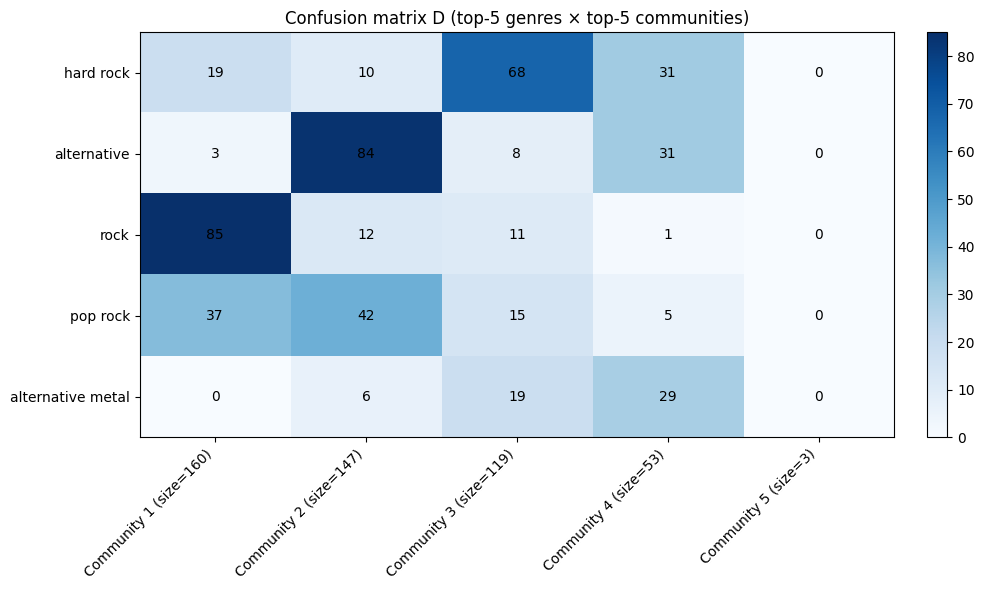

In [38]:
# Build confusion matrix D (top genres x louvain communities)
louvain_community_count = len(sorted_louvain_communities)

# Initialize D 2D array matrix
D = np.zeros((louvain_community_count, louvain_community_count), dtype=int)

most_common_genres = [g for g, _ in genre_counts.most_common(louvain_community_count)]
genre_to_row = {genre: idx for idx, genre in enumerate(most_common_genres)}

node_to_community = {}
for comm_id, comm in enumerate(sorted_louvain_communities):
    for node in comm:
        node_to_community[node] = comm_id

# Fill D: for each node, if node belongs to one of top communities AND has at least one of the top genres,
for node in node_to_community.keys():
    # increment counts for each matching genre (use all genres associated with node)
    matched = False
    for g in genres_dict.get(node, []):
        if g in genre_to_row:
            D[genre_to_row[g], node_to_community[node]] += 1
            matched = True

comm_labels = [f"Community {cid +1} (size={len(comm)})" for cid, comm in enumerate(sorted_louvain_communities)]
df_D = pd.DataFrame(D, index=most_common_genres, columns=comm_labels)

# Plot confusion matrix D
plt.figure(figsize=(10, 6))
im = plt.imshow(df_D.values, cmap="Blues", aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(df_D.columns)), df_D.columns, rotation=45, ha="right")
plt.yticks(range(len(df_D.index)), df_D.index)
plt.title(f"Confusion matrix D (top-{louvain_community_count} genres × top-{louvain_community_count} communities)")

for i in range(df_D.shape[0]):
    for j in range(df_D.shape[1]):
        plt.text(j, i, df_D.iat[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

> Figure 6: The confusion matrix displays the 5 communities identified using the **Louvain algorithm** in relation with the top 5 most common genres.

---

### Genre distribution across communities

Since each band can belong to multiple genres, the sum of the genre counts often exceeds the total number of nodes in a community.

We observe that a single genre typically dominates each community. However, because communities are **not formed based on music genres**, the distribution of genres is spread across multiple categories within each community.

For example, the node with the highest value appears in **Community 1**, which might initially suggest it represents bands mainly associated with **rock**.  
A closer look reveals a substantial presence of **pop rock** as well, illustrating that even this community is **not purely genre-driven**.

**Community 3**, in contrast, appears to be the most **genre-driven** among the five communities.

The distribution of nodes across its main genres is more pronounced: **68 nodes** are associated with **hard rock**, while the next most common genre shown in the matrix has only **19 nodes**.  

However, the true second-largest group within this community is **heavy metal**, with **36 occurrences**, which does not appear in the matrix because it is not among the five most common genres displayed.  
This highlights that, while some communities show stronger genre patterns, genres alone are still **not good indicators of community structure**.


---
#### Conclusion

Overall, the low modularity values across all genre-based strategies demonstrate that **Wikipedia artist links are not primarily formed by shared genres**.  
While genre remains a useful descriptive feature, it does not align well with the network’s actual community structure.
Instead, the data reveals a more complex network of relationships, where **cultural, temporal, and social factors** play a stronger role than genre classification alone.

---

## Communities visualization

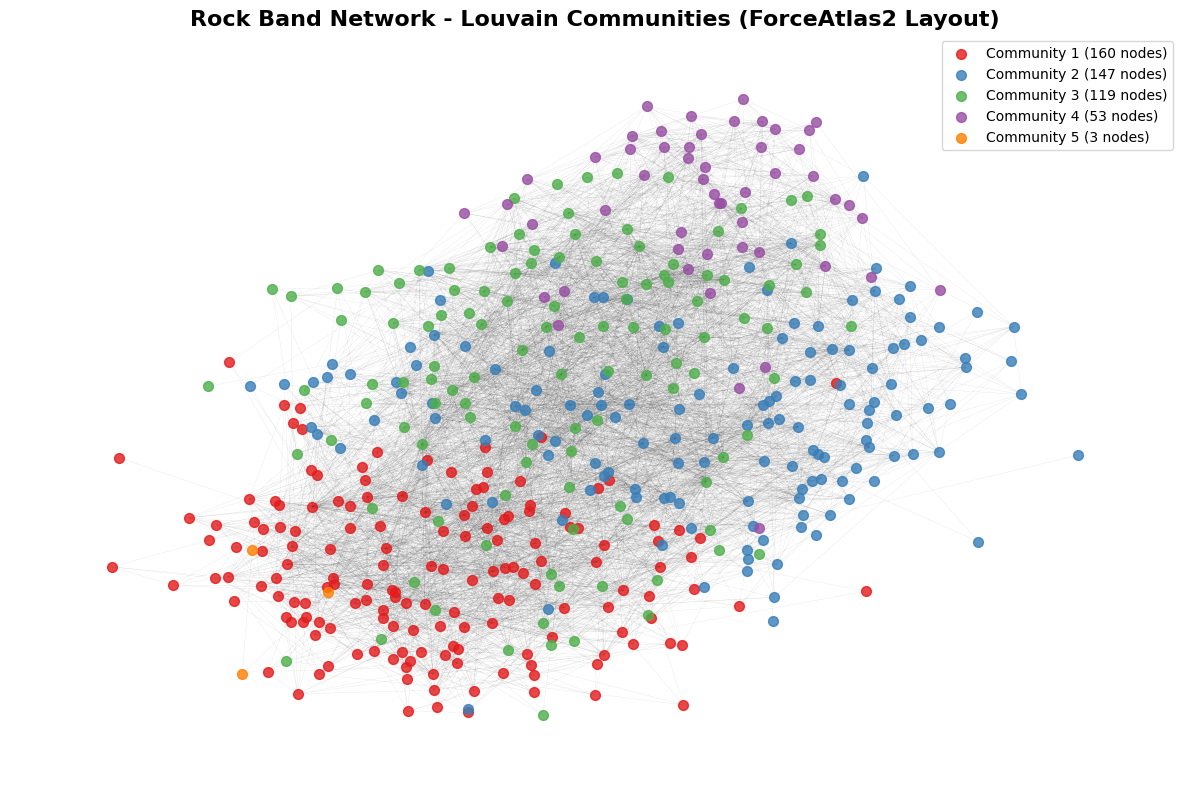

In [39]:
pos = nx.forceatlas2_layout(G_genres, seed=42)

pos_array = np.array(list(pos.values()))
center = pos_array.mean(axis=0)
for k in pos:
    pos[k] = center + (pos[k] - center)

colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]

plt.figure(figsize=(12, 8))

# Draw each community
for idx, nodes_in_comm in enumerate(sorted_louvain_communities):
    nx.draw_networkx_nodes(
        G_genres,
        pos,
        nodelist=list(nodes_in_comm),
        node_color=colors[idx],
        node_size=50,
        alpha=0.8,
        label=f"Community {idx + 1} ({len(nodes_in_comm)} nodes)"
    )

nx.draw_networkx_edges(G_genres, pos, alpha=0.25, width=0.1, edge_color="black")

plt.title("Rock Band Network - Louvain Communities (ForceAtlas2 Layout)",
          fontsize=16, fontweight="bold")
plt.legend(loc="upper right", fontsize=10)
plt.axis("off")
plt.tight_layout()
plt.show()

>Figure 7: The plot shows the grouping of the 5 communities found using the **Louvain algorithm** in different colors using the ForceAtlas2 layout. The layout positions the nodes in 2D space so that connected nodes are close together, while distant nodes repel each other creating a visually meaningful layout.

---

### Community Structure is Visible

- The nodes are grouped into **five communities**, each represented by a distinct color.  
- **Community 1 (red)** being the largest group shows blue and green nodes merged within it.  
- **Communities 2 (blue)** and **3 (green)** are mixed with each other, indicating many connections between communities.  
- **Community 4 (purple)** is moderately sized and somewhat connected to the green and blue communities.  
- **Community 5 (orange)** is tiny and mostly isolated, consistent with its small node count (**3 nodes**).

---

### Overlap and Interconnections

- While communities are defined by the Louvain algorithm, there are still **edges connecting nodes across communities**.  
- This reflects the **real-world nature of music networks** — artists often have **cross-genre influences or collaborations**.

### Size Differences are Apparent

- **Larger communities** (red, blue, green) dominate the network visually, highlighting that the majority of artists fall into these few large clusters.  
- The **smaller communities** (purple, orange) are peripheral, reflecting **niche or specialized groups**.

### Density Patterns

- Communities do not show tight clustering, suggesting **weak internal connectivity**.  
- Some nodes at the edges are less connected, possibly representing **artists with fewer Wikipedia links** or **cross-community connections**.

### Network Insights

- The network structure shows that **connections between artists are not purely genre-based**.  
- **Central communities** likely correspond to **mainstream or highly connected artists**,  
  while **peripheral communities** correspond to **niche genres** (e.g., funk/psychedelic for Community 5).


---

# Part 3: TF-IDF to understand genres and communities

## TF-IDF & How it helps with understanding genres/communities

---
#### **TF-IDF (Term Frequency-Inverse Document Frequency)**

TF-IDF is a method which can help us identify the most important and distinct words for each group (genre or community) in our analysis.
<br>
When creating standard word clouds using simple word counts + filtering, we encountered a fundamental problem that common, unimportant words tend to dominate the visualization.

These were generic stopwords/filler words, or Wikipedia-specific vocabulary that appears on every single band's page regardless of genre.
<br>
Meaning having words like "album, released, rock, tour or band", tell us nothing distinctive about the specific community or genre.

The crucial part of TF-IDF is how it automatically filters out irrelevant words by calculating the inverse document frequency $\text{IDF}(t, D) = \log \left( \frac{N}{n_t} \right)$.
<br>
This means if a word appears in all documents the $\text{TF-IDF} = \text{TF} \times \text{IDF} = 0$, because the IDF part will be $\log \left(\frac{N}{n_t} \right) = \log(1) = 0 $
- where N is the total number of documents
- $n_t$ is the number of documents containing corresponding term

By applying TF-IDF to our music network communities and genres, we can find more unique characteristics and identities of each group.
<br>
And we can use this to check whether communities form around specific genres or more interesting patterns such as influences, time periods and collaborations.

---

## Data Setup
Before calculating the TF-IDF, we need the actual term-frequencies for the 5 communities and top 15 genres for comparison.

So, below we are importing the computed term-frequencies to skip all the python code for parsing wiki content

In [40]:
# Load precomputed term frequencies for genres and communities
raw_base_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/"
local_network_genre_tf = "data/top_15_genre_tf.json.gz"
local_network_louvain_tf = "data/louvain_communities_tf.json.gz"


if os.path.exists(local_network_genre_tf):
    with gzip.open(local_network_genre_tf, "rt", encoding="utf-8") as fh:
        top_15_genre_tf_loaded = json.load(fh)
else:
    r = requests.get(f"{raw_base_url}{local_network_genre_tf}", timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        top_15_genre_tf_loaded = json.load(fh)

if os.path.exists(local_network_louvain_tf):
    with gzip.open(local_network_louvain_tf, "rt", encoding="utf-8") as fh:
        louvain_communities_tf_loaded = json.load(fh)
else:
    r = requests.get(f"{raw_base_url}{local_network_louvain_tf}", timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        louvain_communities_tf_loaded = json.load(fh)

# Convert back to Counter objects
top_15_genre_tf = {
    genre: Counter(word_counts) for genre, word_counts in top_15_genre_tf_loaded.items()
}
louvain_communities_tf = {
    community: Counter(word_counts)
    for community, word_counts in louvain_communities_tf_loaded.items()
}

print(f"Loaded {len(top_15_genre_tf)} genres term frequencies")
print(f"Loaded {len(louvain_communities_tf)} communities term frequencies")

Loaded 15 genres term frequencies
Loaded 5 communities term frequencies


## Calculate TF-IDF for genres & communities

In [41]:
def calculate_tf_idf(term_frequencies: dict[str, Counter]) -> dict[str, dict[str, float]]:
    N = len(term_frequencies)  # Total number of documents
    tf_idf = {}
    for doc in term_frequencies:
        tf_idf[doc] = {}
        for word, term_freq in term_frequencies[doc].items():
            # Calculate document frequency across all documents
            df = sum(1 for d in term_frequencies if word in term_frequencies[d])
            idf = np.log((1 + N) / (1 + df))
            tf_idf[doc][word] = term_freq * idf
    return tf_idf

# Calculated TF-IDF for the top 15 genres and Louvain communities
tf_idf_top_15_genre = calculate_tf_idf(top_15_genre_tf)
tf_idf_louvain_communities = calculate_tf_idf(louvain_communities_tf)

## Visualize TF-IDF for genres & communities

### WordCloud visualization of Top 15 Genres

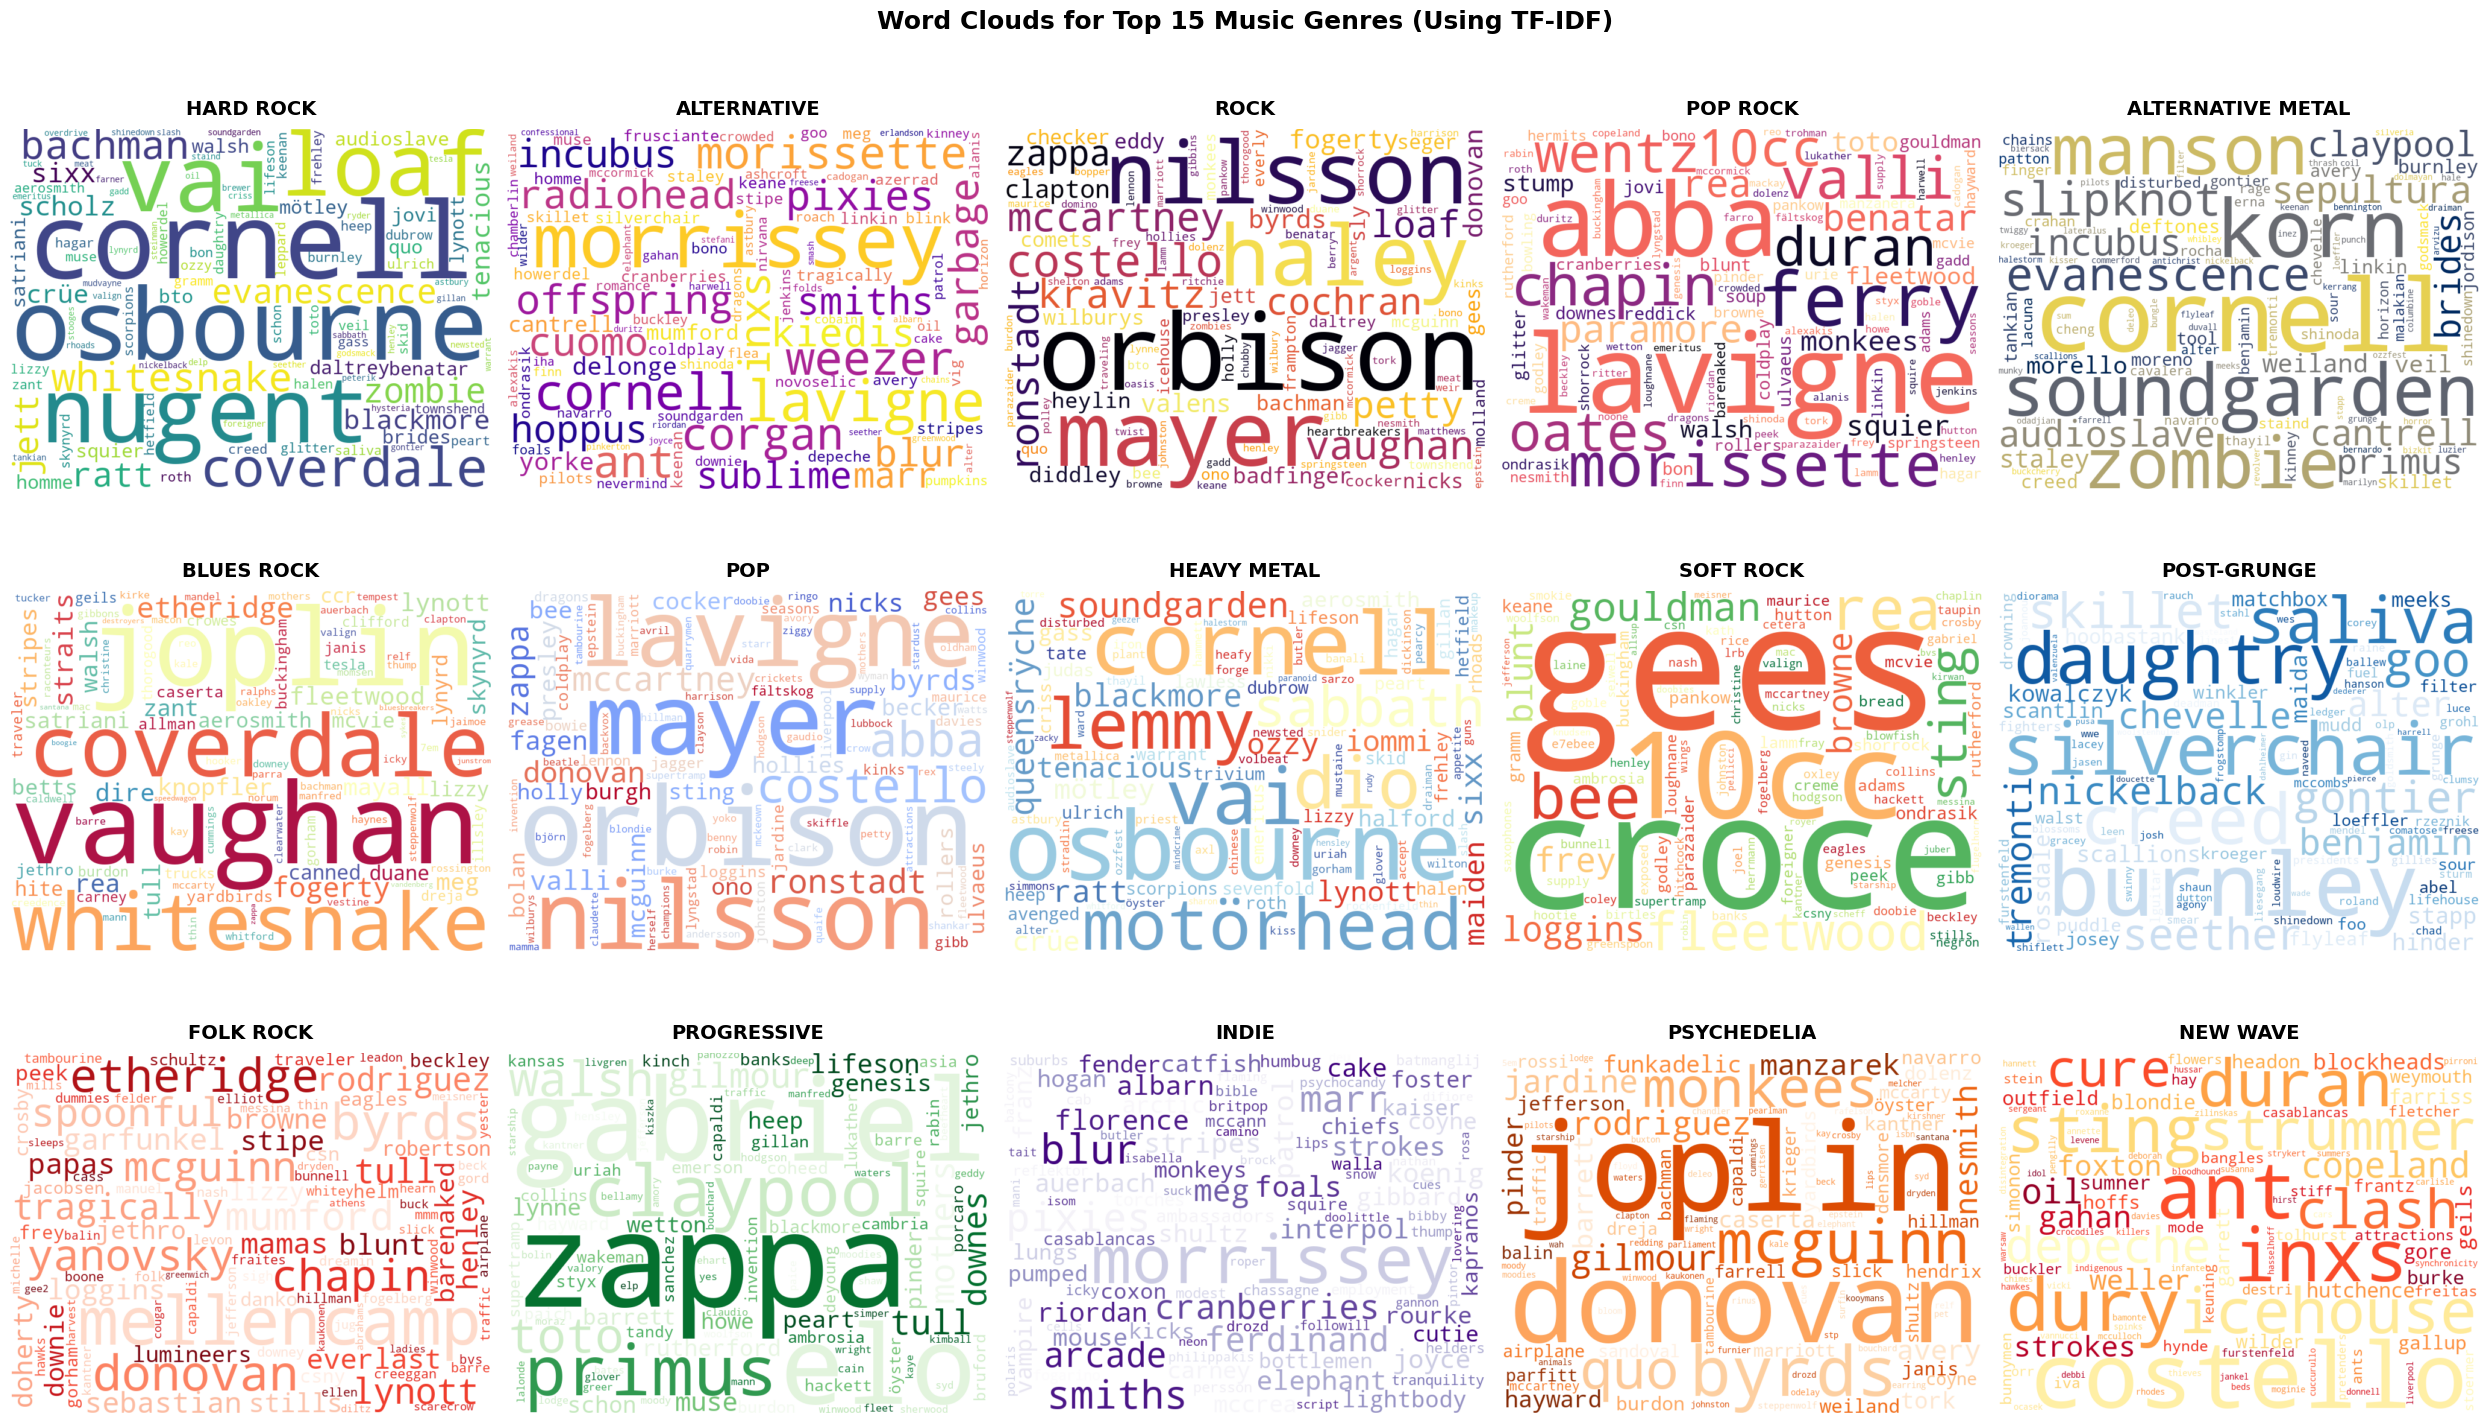

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.flatten()

color_schemes = [
    "viridis",
    "plasma",
    "inferno",
    "magma",
    "cividis",
    "Spectral",
    "coolwarm",
    "RdYlBu",
    "RdYlGn",
    "Blues",
    "Reds",
    "Greens",
    "Purples",
    "Oranges",
    "YlOrRd",
]

for idx, genre in enumerate(tf_idf_top_15_genre.keys()):
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color="white",
        colormap=color_schemes[idx],
        max_words=100,
        collocations=False,
        relative_scaling=0.5,
        min_font_size=10,
    ).generate_from_frequencies(tf_idf_top_15_genre[genre])
    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].set_title(f"{genre.upper()}", fontsize=14, fontweight="bold", pad=10)
    axes[idx].axis("off")

plt.suptitle(
    "Word Clouds for Top 15 Music Genres (Using TF-IDF)",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

> **Figure 8 (Genre Word Clouds):** 15 word clouds showing the most distinctive artists for each music genre, where word size represents TF-IDF importance. Words are scaled by TF-IDF to highlight genre-specific terms rather than common words.

##### Genre wordclouds observations
**Genre specific Artists:**
- **Indie** is dominated by Morrissey from the band The Smiths with a score of 675. Almost more than 4 times the next term.
- **Pop & Rock** is dominated by Roy Orbison dominated in both categories
- **Folk Rock**: John Mellencamp (431 score, double anyone else)

**Cross-Genre Artists:**
- **Chris Cornell** appears in 4 genres (Alternative, Alternative Metal, Heavy Metal, Hard Rock).
- **Avril Lavigne** is prominent in Alternative, Pop Rock, and Pop

**Absences of most popular bands:**

It seems like when a band gets too big and exist across all genres, TF-IDF masks their influence in the documents. These could be huge bands/artist such as Led Zeppelin, Rolling Stones, Nirvana.


This means that TF-IDF does not reveal the most *famous/influential*, but the most *distinctive* for each genre.

---

### WordCloud visualization of Louvain communities

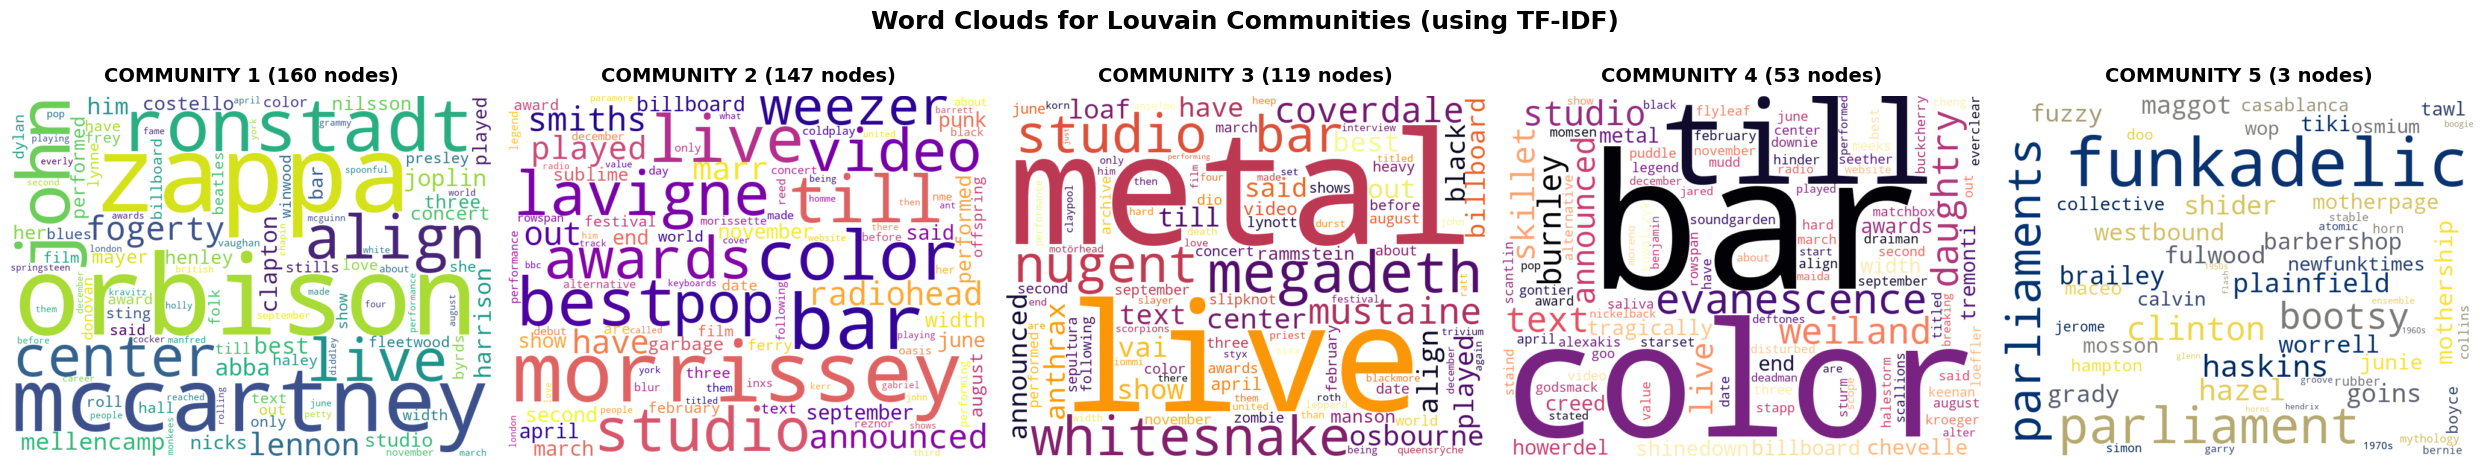

In [43]:
fig, axes = plt.subplots(1, len(sorted_louvain_communities), figsize=(len(sorted_louvain_communities)*5, 5))

color_schemes = [
    "viridis",
    "plasma",
    "inferno",
    "magma",
    "cividis",
    "Spectral",
    "coolwarm",
    "RdYlBu",
    "RdYlGn",
    "Blues",
    "Reds",
    "Greens",
    "Purples",
    "Oranges",
    "YlOrRd",
]

for idx in range(len(sorted_louvain_communities)):
    community_label = f"Community_{idx + 1}"
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color="white",
        colormap=color_schemes[idx],
        max_words=100,
        collocations=False,
        relative_scaling=0.5,
        min_font_size=10,
    ).generate_from_frequencies(tf_idf_louvain_communities[community_label])

    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].set_title(
        f"COMMUNITY {idx + 1} ({len(sorted_louvain_communities[idx])} nodes)",
        fontsize=14,
        fontweight="bold",
        pad=10,
    )
    axes[idx].axis("off")

plt.suptitle(
    "Word Clouds for Louvain Communities (using TF-IDF)",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

> **Figure 9 (Community Word Clouds):** 5 word clouds representing Louvain communities, with word size indicating TF-IDF scores.

#### Louvain Community word-cloud observations

- **Community 1:** Is primarily dominated by the Beatles era (Lennon, McCartney). So we can assume that this community clustering could be a representation of the the classic rock era during that time period.

- **Community 2:** The presence of Morrissey plus Avril lavigne could suggest a community of Alternative/Indie of the 1990s - 2000s. However, there are some generic terms such "bar, color, studio and awards" that feels like the wiki content of these artists are a bit different than others.

- **Community 3:** This is a heavily metal genre dominated community with names such as megadeth, whitesnake and Ozzy.

- **Community 4:** For some reason the terms like "color and bar" seem to be dominating the wordcloud, suggesting a unique wikipedia structure compared to other communities. However, if we look past those terms, we can see the community contains artists from the 2000s Rock scene like: Evanescence, Daughtry and Skillet.


- **Community 5:** This community is an isolated part of the network, which represents the Parliament-Funkadelic (P-Funk) and their members and collaborators. Suggesting that they had their own unique closed circle.


In summary, we can observe that the tf-idf method has helped us gain a better insight into the louvain communities, where were able to identify genres, but also specific eras, collaborators and the P-Funk group all by themselves in our network. However, there is still room for improvement, so for example the 4th community can have a much clearer wordcloud.

---

## Word Clouds differences between genre & community

Both genre and community word clouds show primarily artist names. However, the key difference is which artists appear and why.

- Genre word clouds shows us the categorization of music done by such as music labels, marketers and journalists which ended up being in the wikipedia page content.
- Community word clouds show us which artists are actually connected to each other based on collaboration, inspiration and references, which caused them to form a clustering in the network.

And comparing these results with the confusion matrix in part 2, we saw misalignments because genre labels don't perfectly predict who mentions who.

For example, "Hard Rock artists/bands" are split between communities 3 and 4, because some reference each other more than others, creating separate network clusters. Or for example pop rock splits across three communities because it's a broad label, which can apply to all over the network without correlating to a specific clustering/community effect.

---

# Part 4: Sentiment of the artists and communities

## Sentiment Analysis Setup

The function to calculate the sentiment score makes use of the dataset (Data Set S1) from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) which contains the average sentiment score of over 10.000 words.

In [44]:
# Fetch sentimantal scores from dataset
local_sentiment_data = "data/Data_Set_S1.txt"
raw_sentiment_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_sentiment_data}"

if os.path.exists(local_sentiment_data):
    df = pd.read_csv(local_sentiment_data, sep="\t", skiprows=2, header=0)
else:
    r = requests.get(raw_sentiment_url, timeout=30)
    r.raise_for_status()
    with io.StringIO(r.text) as fh:
        df = pd.read_csv(fh, sep="\t", skiprows=2, header=0)

df["word"] = df["word"].astype("string")
for col in ["twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]:
    df[col] = df[col].replace("--", np.nan)
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
    
df.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

   twitter_rank  google_rank  nyt_rank  lyrics_rank  
0          3600         <NA>      <NA>         1728  
1          1853         2458      <NA>         1230  
2            25          317       328           23  
3            65         1372      1313          375  
4          3334         3542      <NA>         2332

In [45]:
word_to_happiness_avg = dict(zip(df["word"], df["happiness_average"]))

def sentiment_score(text: str):
    tokens_lower = text.lower().split()
    scores = [
        word_to_happiness_avg[token] for token in tokens_lower if token in word_to_happiness_avg
    ]
    if scores:
        return sum(scores) / len(scores)
    return None

print("Sentiment dataset statistics:")
print(f"Total words with sentiment scores: {len(word_to_happiness_avg)}")
print(f"Dataset min sentiment score: {min(word_to_happiness_avg.values())}")
print(f"Dataset max sentiment score: {max(word_to_happiness_avg.values())}")
print(f"Dataset mean sentiment score: {np.mean(list(word_to_happiness_avg.values())):.4f}")
print(f"Dataset percentiles (25%, Median, 75%):", np.percentile(list(word_to_happiness_avg.values()), [25, 50, 75]))

Sentiment dataset statistics:
Total words with sentiment scores: 10222
Dataset min sentiment score: 1.3
Dataset max sentiment score: 8.5
Dataset mean sentiment score: 5.3752
Dataset percentiles (25%, Median, 75%): [4.9  5.44 6.02]


## Calculate band sentiment score

To prevent fetching all of the bands wikipage in this notebook, we have exported the band sentiment scores which has been calculated using the function above.

This makes it simple to update our existing network and simply add an additional node property

In [46]:
# Load precomputed band sentiment scores
local_network = "data/band_sentiment_scores.json.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_network}"

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        band_sentiment_scores: dict = json.load(fh)
    print(f"Loaded sentiment scores for {len(band_sentiment_scores)} bands.")
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        band_sentiment_scores: dict = json.load(fh)
    print(f"Loaded sentiment scores for {len(band_sentiment_scores)} bands.")

Loaded sentiment scores for 484 bands.


In [47]:
# Assign sentiment scores to bands in G_genres
for band, score in band_sentiment_scores.items():    
    if band in G_genres:
        G_genres.nodes[band]["sentiment"] = score
print(f"Check band sentiment score example:\nAC/DC score: {G_genres.nodes['AC/DC']['sentiment']}")

Check band sentiment score example:
AC/DC score: 5.515908244826454


## Visualize band sentiments

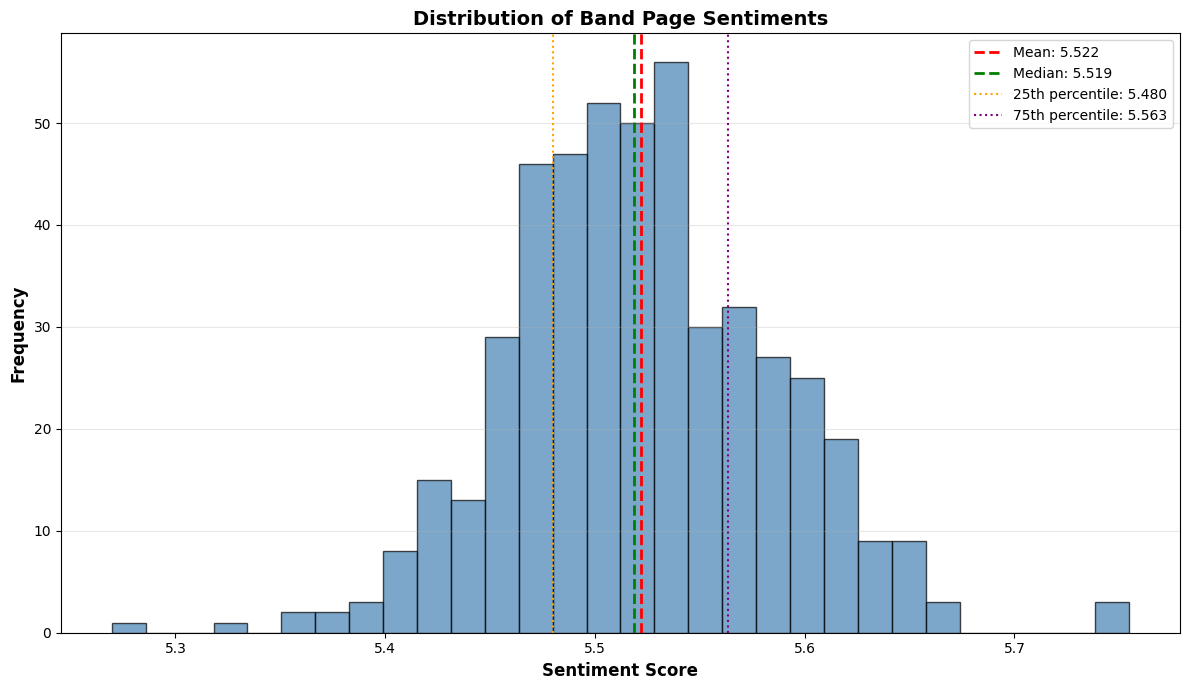

In [48]:
import matplotlib.pyplot as plt

# Calculate statistics
band_sentiments = [
    G_genres.nodes[node]["sentiment"]
    for node in G_genres.nodes()
]
mean_sentiment = round(np.mean(band_sentiments), 4)
median_sentiment = round(np.median(band_sentiments), 4)
p25_sentiment = round(np.percentile(band_sentiments, 25), 4)
p75_sentiment = round(np.percentile(band_sentiments, 75), 4)

# Create figure and plot
fig, ax = plt.subplots(figsize=(12, 7))

# Histogram
ax.hist(band_sentiments, bins=30, color="steelblue", edgecolor="black", alpha=0.7)

# Add vertical lines for statistics
ax.axvline(mean_sentiment, color="red", linestyle="--", linewidth=2, label=f"Mean: {mean_sentiment:.3f}")
ax.axvline(median_sentiment, color="green", linestyle="--", linewidth=2, label=f"Median: {median_sentiment:.3f}")
ax.axvline(p25_sentiment, color="orange", linestyle=":", linewidth=1.5, label=f"25th percentile: {p25_sentiment:.3f}")
ax.axvline(p75_sentiment, color="purple", linestyle=":", linewidth=1.5,label=f"75th percentile: {p75_sentiment:.3f}")

# Labels and title
ax.set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
ax.set_title("Distribution of Band Page Sentiments", fontsize=14, fontweight="bold")
ax.legend(fontsize=10, loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

> Figure 10: The histogram shows the distribution of sentiment scores across bands, which follows an approximately **normal distribution** centered around a mean of **5.522**.  
> This value is very close to the mean sentiment score of the overall sentiment dataset (**5.375**).  
> The sentiment scores among bands range from **5.3 to 5.8**, indicating a **very small variance** and suggesting that bands are described with relatively similar sentiment levels.  
> In contrast, the full sentiment dataset spans a much wider range (from **1.3 to 8.5**) reflecting a **broader diversity of word sentiments** overall.


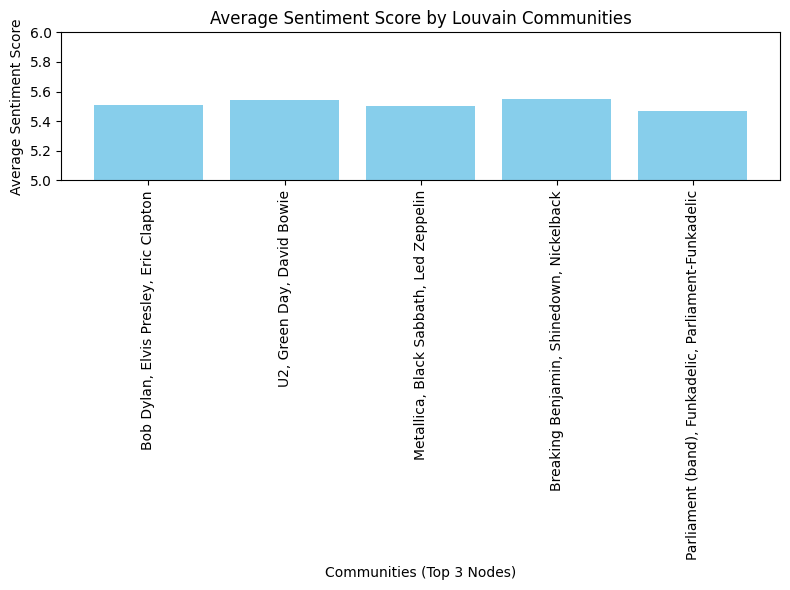

In [49]:
louvain_community_sentiments = []
for i, comm in enumerate(sorted_louvain_communities):
    comm_sentiments = []
    for node in comm:
        sentiment = G_genres.nodes[node].get('sentiment')
        if sentiment is not None:
            comm_sentiments.append(sentiment)
    if comm_sentiments:
        avg_sentiment = sum(comm_sentiments) / len(comm_sentiments)
    else:
        avg_sentiment = None
    louvain_community_sentiments.append((i, len(comm), avg_sentiment))

# name communities by the 3 most connected bands/nodes
comm_names = []
for i, comm in enumerate(sorted_louvain_communities):
    subgraph = G_genres.subgraph(comm)
    degrees = subgraph.degree()
    top_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)[:3]
    name = ", ".join([n[0] for n in top_nodes])
    comm_names.append(name)

# Plot community sentiments
comm_ids = [c[0] for c in louvain_community_sentiments]
comm_sizes = [c[1] for c in louvain_community_sentiments]
comm_avg_sentiments = [c[2] for c in louvain_community_sentiments]

plt.figure(figsize=(8, 6))
plt.bar(comm_ids, comm_avg_sentiments, color='skyblue')
plt.xticks(comm_ids, comm_names, rotation=90)
plt.xlabel("Communities (Top 3 Nodes)")
plt.ylabel("Average Sentiment Score")
# NOTE: Adjust y-limits to focus on sentiment score range
plt.ylim(5,6)
plt.title("Average Sentiment Score by Louvain Communities")
plt.tight_layout()
plt.show()

>**Figure 11 (Community Sentiment Bar Chart):** Average sentiment scores for 5 Louvain communities, each labeled by its top 3 artists. All communities show similar sentiment scores (5.45–5.58).

The bar plot displays the **average sentiment scores** for each of the five Louvain communities, which are labeled according to the **3 nodes with the highest degree** in each.

The sentiment scores are nearly identical across communities (which is why we had too zom in on the y-axis to show small deviations), indicating a **uniform distribution of sentiment** around 5.5 which is the artists mean score throughout the network.

This suggests that the overall tone or descriptive sentiment associated with artists is consistent, regardless of their community grouping.

---

## Community sentiment analysis discussion & findings

### 1. Neutral tone of Wikipedia
Wikipedia pages are intentionally written to maintain a neutral and factual tone. 

As a result, sentiment scores across pages tend to cluster around neutrality, with little emotional variation. We see that the median and the mean are exactly the same value and the distribution of sentiment scores is uniform.

### 2. High vocabulary Overlap
The majority of words are shared among pages, as confirmed by word cloud analysis. 

This reflects the standardized structure and style of Wikipedia articles, for example sections like Early Life, Discography, Reception of each page.

### 3. Consistent node sentiments
When evaluating each node (individual page) separately, sentiment scores remain very similar. 

This further supports the hypothesis that Wikipedia’s editorial guidelines minimize emotional language.

### 4. Community-level analysis adds little value
Aggregating nodes into communities does not provide additional insight.

Since nodes within a community have nearly identical sentiment distributions, the community sentiment averages out, revealing no meaningful differentiation between them.

### 5. Relation with TF-IDF

The sentiment analysis of the structural communities showed that there was **no clear relationship** between the sentiment of the words used to describe the artists on Wikipedia and the way they form structural communities. Likewise, there was **no evident relationship** between the artists’ genres and the language used to describe them within those genres.

**Term frequency alone** does not capture what is distinctive about a text.  
It mainly reflects words that are frequent across all texts, which leads to a conclusion similar to the sentiment analysis:  
words shared across all genres relate to **common terms for music** or **very popular bands** that are cited by most artists regardless of genre.

In contrast, **TF-IDF** helps identify words that are **common within a specific genre** but **rare across others**.  
This allows us to see the **particular bands or terms distinctive to each genre**.  
However, this distinction is **not evident in the overall sentiment analysis**, since there is no weighting applied to distinctive words per group.

---
### 6. Other findings

Building on the TF-IDF analysis, where the most relevant words associated with each genre were often the names of artists, we explored whether the most frequently cited artist names within each community were related to the community’s happiness level. To do so, we compared the average happiness of each community with the sentiment of its name, defined by the three most connected (and therefore most cited) artists within it. Although no clear correlation was found given that all communities sentiment scores are very close to the mean, the happiest community included name-matching words such as “david”, which showed higher sentiment scores than those in the saddest community, where the matching words included “black.”
